In [1]:
import numpy as np
import matplotlib.pyplot as plt
import dkistpkg_ct as dp
from importlib import reload
from scipy.stats import skew
from sklearn import preprocessing
from scipy.optimize import curve_fit
import tol_colors

#### Most of this code is taken from pltmodelingresult which is in the DKIST_Data_Tools folder.  Remade for explicit use for the paper

In [84]:
root = '/Users/coletamburri/Desktop/DKIST_Data_Tools_misc/ViSP2G_fits_npzfiles/'

caII_low = 480
caII_high = 650
hep_low = 700
hep_high = 850
wl = 396.847 # central wavelength, Ca II H # defined by comparison to atlas
wl_hep=397.007

def color_muted2():
    muted =['#332288', '#88CCEE', '#44AA99','#117733','#999933','#DDCC77', '#CC6677','#882255','#AA4499','#DDDDDD']
#  0= indigo
# 1 = cyan
# 2 = teal
# 3 = green
# 4 = olive
# 5= sand
# 6 = rose
# 7 = wine
# 8 = purple
# 9=grey
    return muted

muted = color_muted2()

def conv_to_vel(mu1,mu2,mu,lamb0 = 396.847,c=2.99e5):
    vel1 = []
    vel2 = []
    
    shift1 = []
    shift2 = []
    
    for i in range(len(mu1)):
        shift1.append(mu1[i]-lamb0)
        shift2.append(mu2[i]-lamb0)
        
    for i in range(len(mu1)):
        
        vel1.append(((((shift1[i]+lamb0)/lamb0)-1)*c)/mu)
        vel2.append(((((shift2[i]+lamb0)/lamb0)-1)*c)/mu)
        
    return vel1, vel2



def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx], idx

def normalize(arr):
    norm_arr = []
    minimum = np.nanmin(arr)
    maximum = np.nanmax(arr)
    diff_arr = maximum - minimum   
    for i in arr:
        temp = (i - minimum)/(maximum-minimum)
        norm_arr.append(temp)
    return norm_arr

c=2.99e5
lamb0 = 396.847
lamb1 = 397.007
mu = 0.4760111410077789

def veltrans(x):
    return ((((x+lamb0)/lamb0)-1)*c)/mu

def wltrans(x):
    return ((((x/c)+1)*lamb0)-lamb0)

def gaussian(x, c1, mu1, sigma1):
    res = c1 * np.exp( - (x - mu1)**2.0 / (2.0 * sigma1**2.0) )
    return res

def gaussfit(params,selwl,sel):
    fit = gaussian( selwl, params )
    return (fit - sel)

def double_gaussian( x, c1, mu1, sigma1, c2, mu2, sigma2 ):
    res =   (c1 * np.exp( - (x - mu1)**2.0 / (2.0 * sigma1**2.0) )) \
          + (c2 * np.exp( - (x - mu2)**2.0 / (2.0 * sigma2**2.0) ))
    return res

In [3]:
# fits - plotting
fits2g = '/Users/coletamburri/Desktop/August_2022_Observations_Paper/fits2g.npz'
centfits = root+'centfits.npz'

data_cent = np.load(centfits)
fits2g_arr = np.load(fits2g)

In [4]:
fits2g_arr

NpzFile '/Users/coletamburri/Desktop/August_2022_Observations_Paper/fits2g.npz' with keys: arr_0, arr_1, arr_2, arr_3, arr_4

In [5]:
shifts1 = fits2g_arr['arr_0']
shifts2 = fits2g_arr['arr_1']
errs1 = fits2g_arr['arr_2']
errs2 = fits2g_arr['arr_3']
timesraster1 = fits2g_arr['arr_4']

In [6]:
timesraster1[0:7][-7:]

array(['2022-08-19T20:42:07.510', '2022-08-19T20:42:33.514',
       '2022-08-19T20:42:59.517', '2022-08-19T20:43:25.521',
       '2022-08-19T20:43:51.525', '2022-08-19T20:44:17.529',
       '2022-08-19T20:44:43.502'], dtype='<U23')

2025-12-29 08:55:53 - matplotlib.category - INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-12-29 08:55:53 - matplotlib.category - INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-12-29 08:55:53 - matplotlib.category - INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


<ErrorbarContainer object of 3 artists>

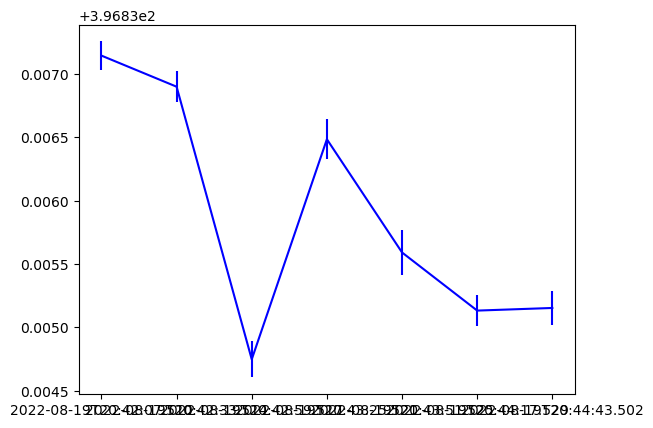

In [7]:
fig,ax = plt.subplots()
ax.errorbar(timesraster1[0:7][-7:],shifts1,yerr=errs1,color='blue')


In [11]:
def conv_to_vel(mu1,mu2,mu,lamb0 = 396.847,c=2.99e5):
    vel1 = []
    vel2 = []
    
    shift1 = []
    shift2 = []
    
    for i in range(len(mu1)):
        shift1.append(mu1[i]-lamb0)
        shift2.append(mu2[i]-lamb0)
        
    for i in range(len(mu1)):
        
        vel1.append(((((shift1[i]+lamb0)/lamb0)-1)*c)/mu)
        vel2.append(((((shift2[i]+lamb0)/lamb0)-1)*c)/mu)
        
    return vel1, vel2

In [12]:
mu =  0.4760111410077789 #location of AR
vels1, vels2 = conv_to_vel(shifts1,shifts2,mu)
maxerrvels1, maxerrvels2 = conv_to_vel(shifts1+errs1,shifts2+errs2,mu)
errvels1 = np.abs(np.subtract(maxerrvels1,vels1))
errvels2 = np.abs(np.subtract(maxerrvels2,vels2))

In [13]:
vels1

[np.float64(-15.60095814744963),
 np.float64(-15.989007290128702),
 np.float64(-19.393791976647933),
 np.float64(-16.645455302926464),
 np.float64(-18.059177587973863),
 np.float64(-18.784948397758413),
 np.float64(-18.75211864728139)]

In [14]:
errvels1

array([0.17651484, 0.19015812, 0.22638138, 0.24878674, 0.27620268,
       0.19649771, 0.21430375])

In [15]:
vels2

[np.float64(10.408152278070292),
 np.float64(10.676294629783362),
 np.float64(9.73424727658417),
 np.float64(8.552013115387835),
 np.float64(6.312874789177366),
 np.float64(7.780647086368932),
 np.float64(7.380133499877086)]

In [16]:
errvels2

array([0.18169935, 0.21674898, 0.27703534, 0.26788398, 0.22664302,
       0.21613627, 0.22577792])

In [18]:
timesstr = [i[-12:-4] for i in timesraster1]
timesstr

['20:42:07',
 '20:42:33',
 '20:42:59',
 '20:43:25',
 '20:43:51',
 '20:44:17',
 '20:44:43',
 '20:45:09',
 '20:45:35',
 '20:46:01',
 '20:46:27']

2025-12-29 09:01:40 - matplotlib.category - INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-12-29 09:01:40 - matplotlib.category - INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-12-29 09:01:40 - matplotlib.category - INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-12-29 09:01:40 - matplotlib.category - INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-12-29 09:01:40 - matplotlib.categor

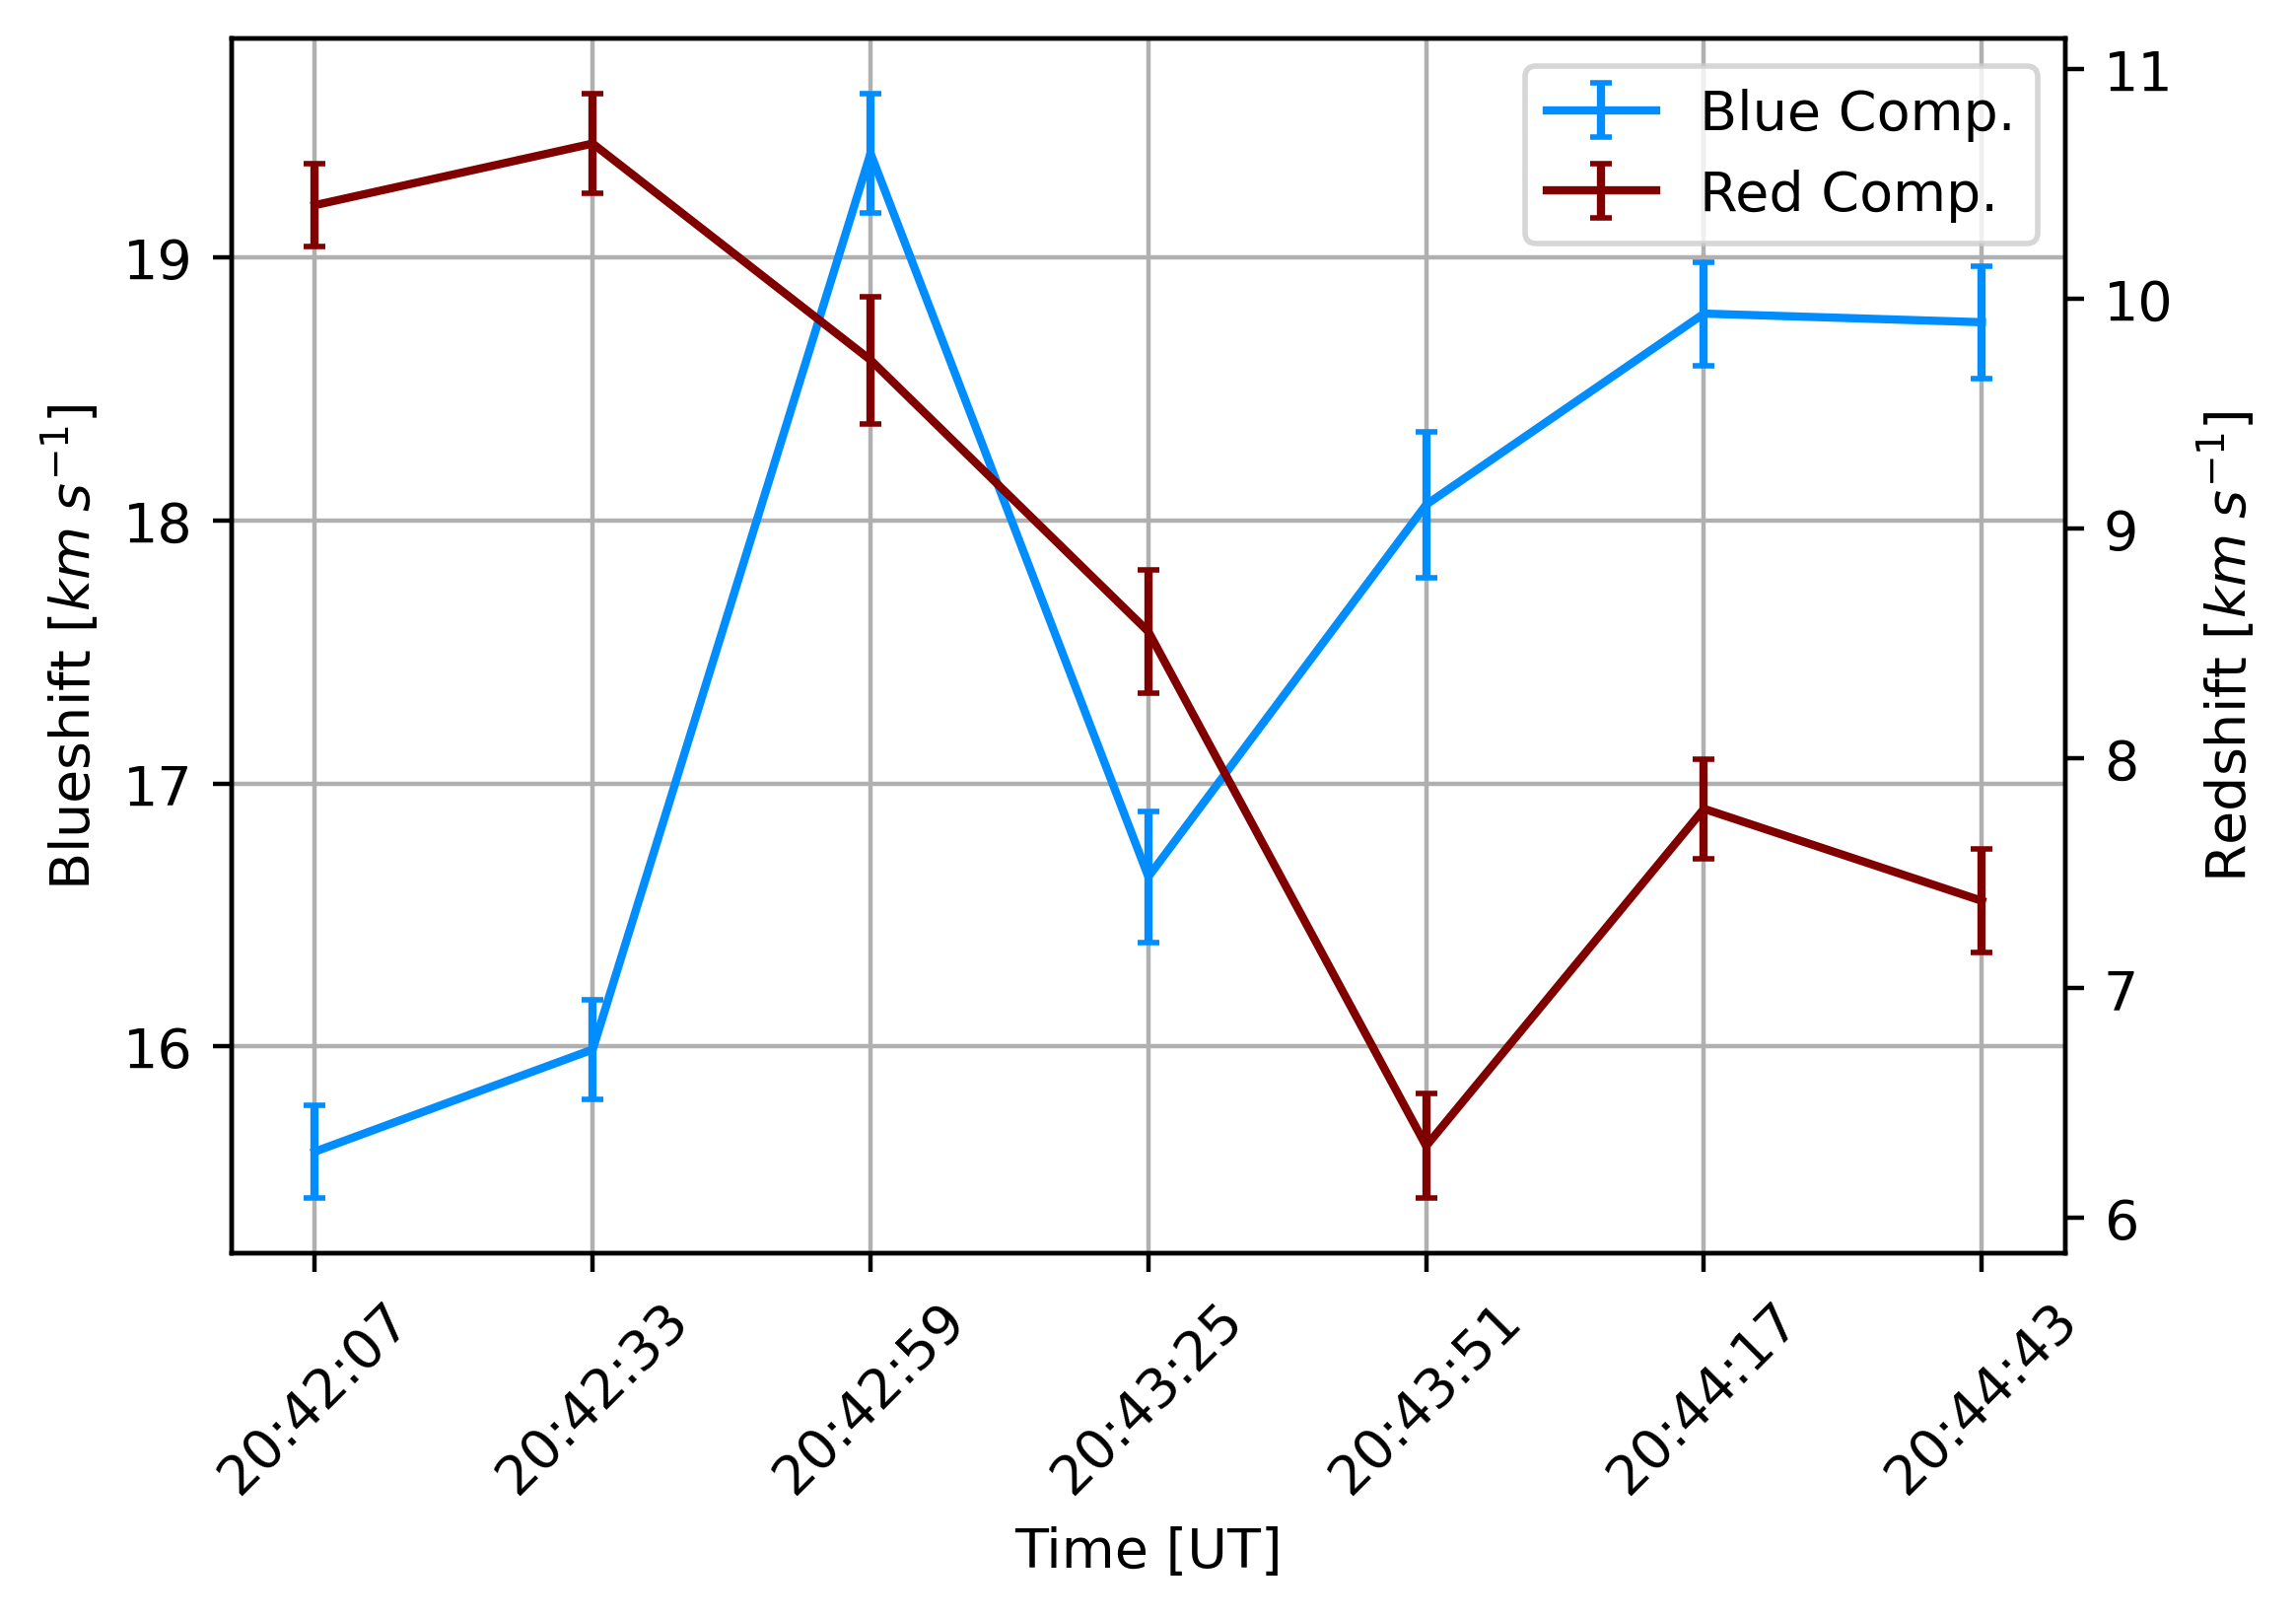

In [66]:
fig,ax=plt.subplots(figsize=(6,4),dpi=400)
lns1 = ax.errorbar(timesstr[0:7],np.abs(vels1),yerr =errvels1,capsize=2,color=colors[5],label='Blue Comp.')
ax1 = ax.twinx()
lns2 = ax1.errorbar(timesstr[0:7],vels2,yerr =errvels2,capsize=2,color=colors[19],label='Red Comp.')
ax.set_xlabel('Time [UT]')
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax1.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc=0,fontsize=10)
labs = ['Red Comp.','','Blue Comp.','']
ax.set_ylabel(r'Blueshift [$km\;s^{-1}$]')
ax1.set_ylabel(r'Redshift [$km\;s^{-1}$]')
ax.grid()
ax.set_xticks(timesstr[0:7], timesstr[0:7], rotation=45)


In [20]:
storeamp1_2_on = data_cent['arr_0']
storeamp2_2_on = data_cent['arr_1']
storesig1_2_on = data_cent['arr_2']
storesig2_2_on = data_cent['arr_3']
storemu1_2_on = data_cent['arr_4']
storemu2_2_on = data_cent['arr_5']
bkgd_subtract_flaretime = data_cent['arr_6']
dispersion_range_fin_on = data_cent['arr_7']
spatial_range = data_cent['arr_8']
maxindices = data_cent['arr_9']

In [21]:
np.shape(spatial_range)

(2544,)

In [22]:
#example convolution with gaussian psf
def gaussian_psf_space(x, fwhm):
	#x = space [pix]
	# fwhm in [pix]
    sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))  # Calculate sigma from FWHM
    tr = np.exp(-(x)**2 / (2 * (sigma**2)))
    tr /= tr.sum()
    return tr
#write adjustment for point spread function from atlas

def psf_adjust(wlsel,ilamsel,fwhm,new_dispersion_range,ntw,gaussian_psf):
   
    
    func=interp1d(wlsel,ilamsel,kind='linear',fill_value='extrapolate')
    yatlas = func(new_dispersion_range)
    dw=new_dispersion_range[1]-new_dispersion_range[0]
    dw=dw
    tw=(np.arange(ntw)-ntw//2)*dw
    
    for i in range(1):

    	psf = gaussian_psf(tw, fwhm) # guassian transmission profiles
    	yconv = convolve(yatlas, psf, mode='same', method='fft')
        
    return yconv

from scipy.interpolate import interp1d
from scipy.signal import convolve

In [26]:
spatial_range2 = np.insert(spatial_range,0,spatial_range[0]-(spatial_range[1]-spatial_range[0]))

In [27]:
dispersion_range_fin_on[480]

np.float64(396.7858838032756)

In [28]:
dispersion_range_fin_on[650]

np.float64(396.916538043193)

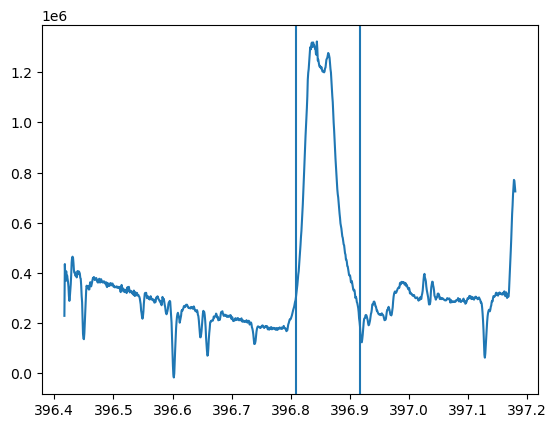

In [29]:
fig,ax=plt.subplots()
ax.plot(dispersion_range_fin_on,bkgd_subtract_flaretime[0,:,1500])
ax.axvline(dispersion_range_fin_on[510])
ax.axvline(dispersion_range_fin_on[650])

In [30]:
dispersion_range_fin_on[620]

np.float64(396.89348141261934)

In [31]:
img1 = bkgd_subtract_flaretime[0,510:620,1200:1550]
img2 = bkgd_subtract_flaretime[1,510:620,1200:1550]
img3 = bkgd_subtract_flaretime[2,510:620,1200:1550]
img4 = bkgd_subtract_flaretime[3,510:620,1200:1550]
img5 = bkgd_subtract_flaretime[4,510:620,1200:1550]
img6 = bkgd_subtract_flaretime[5,510:620,1200:1550]
img7 = bkgd_subtract_flaretime[6,510:620,1200:1550]

[X,Y]= np.meshgrid(spatial_range2[1200:1551],dispersion_range_fin_on[510:621])

In [32]:
mincbar = np.min(img1)
maxcbar = np.max(img1)

In [33]:
selwl = dispersion_range_fin_on[caII_low:caII_high]

In [43]:
selwlshift=selwl-lamb0
gauss2fity = double_gaussian(selwl,storeamp1_2_on[0],storemu1_2_on[0],storesig1_2_on[0],\
                             storeamp2_2_on[0],storemu2_2_on[0],storesig2_2_on[0])

comp1fity = gaussian(selwl,storeamp1_2_on[0],storemu1_2_on[0],storesig1_2_on[0])
comp2fity = gaussian(selwl,storeamp2_2_on[0],storemu2_2_on[0],storesig2_2_on[0])

gauss2fitynorm = normalize(gauss2fity)
# comp1fitynorm = (comp1fity - min(gauss2fity))/(max(gauss2fity)-min(gauss2fity))
# comp2fitynorm = (comp2fity - min(gauss2fity))/(max(gauss2fity)-min(gauss2fity))


In [44]:
# fit single gaussian
fit = curve_fit(gaussian,selwl,sels[10],p0=[3e6,396.85,.02])
gauss1fit = gaussian(selwl,fit[0][0],fit[0][1],fit[0][2])

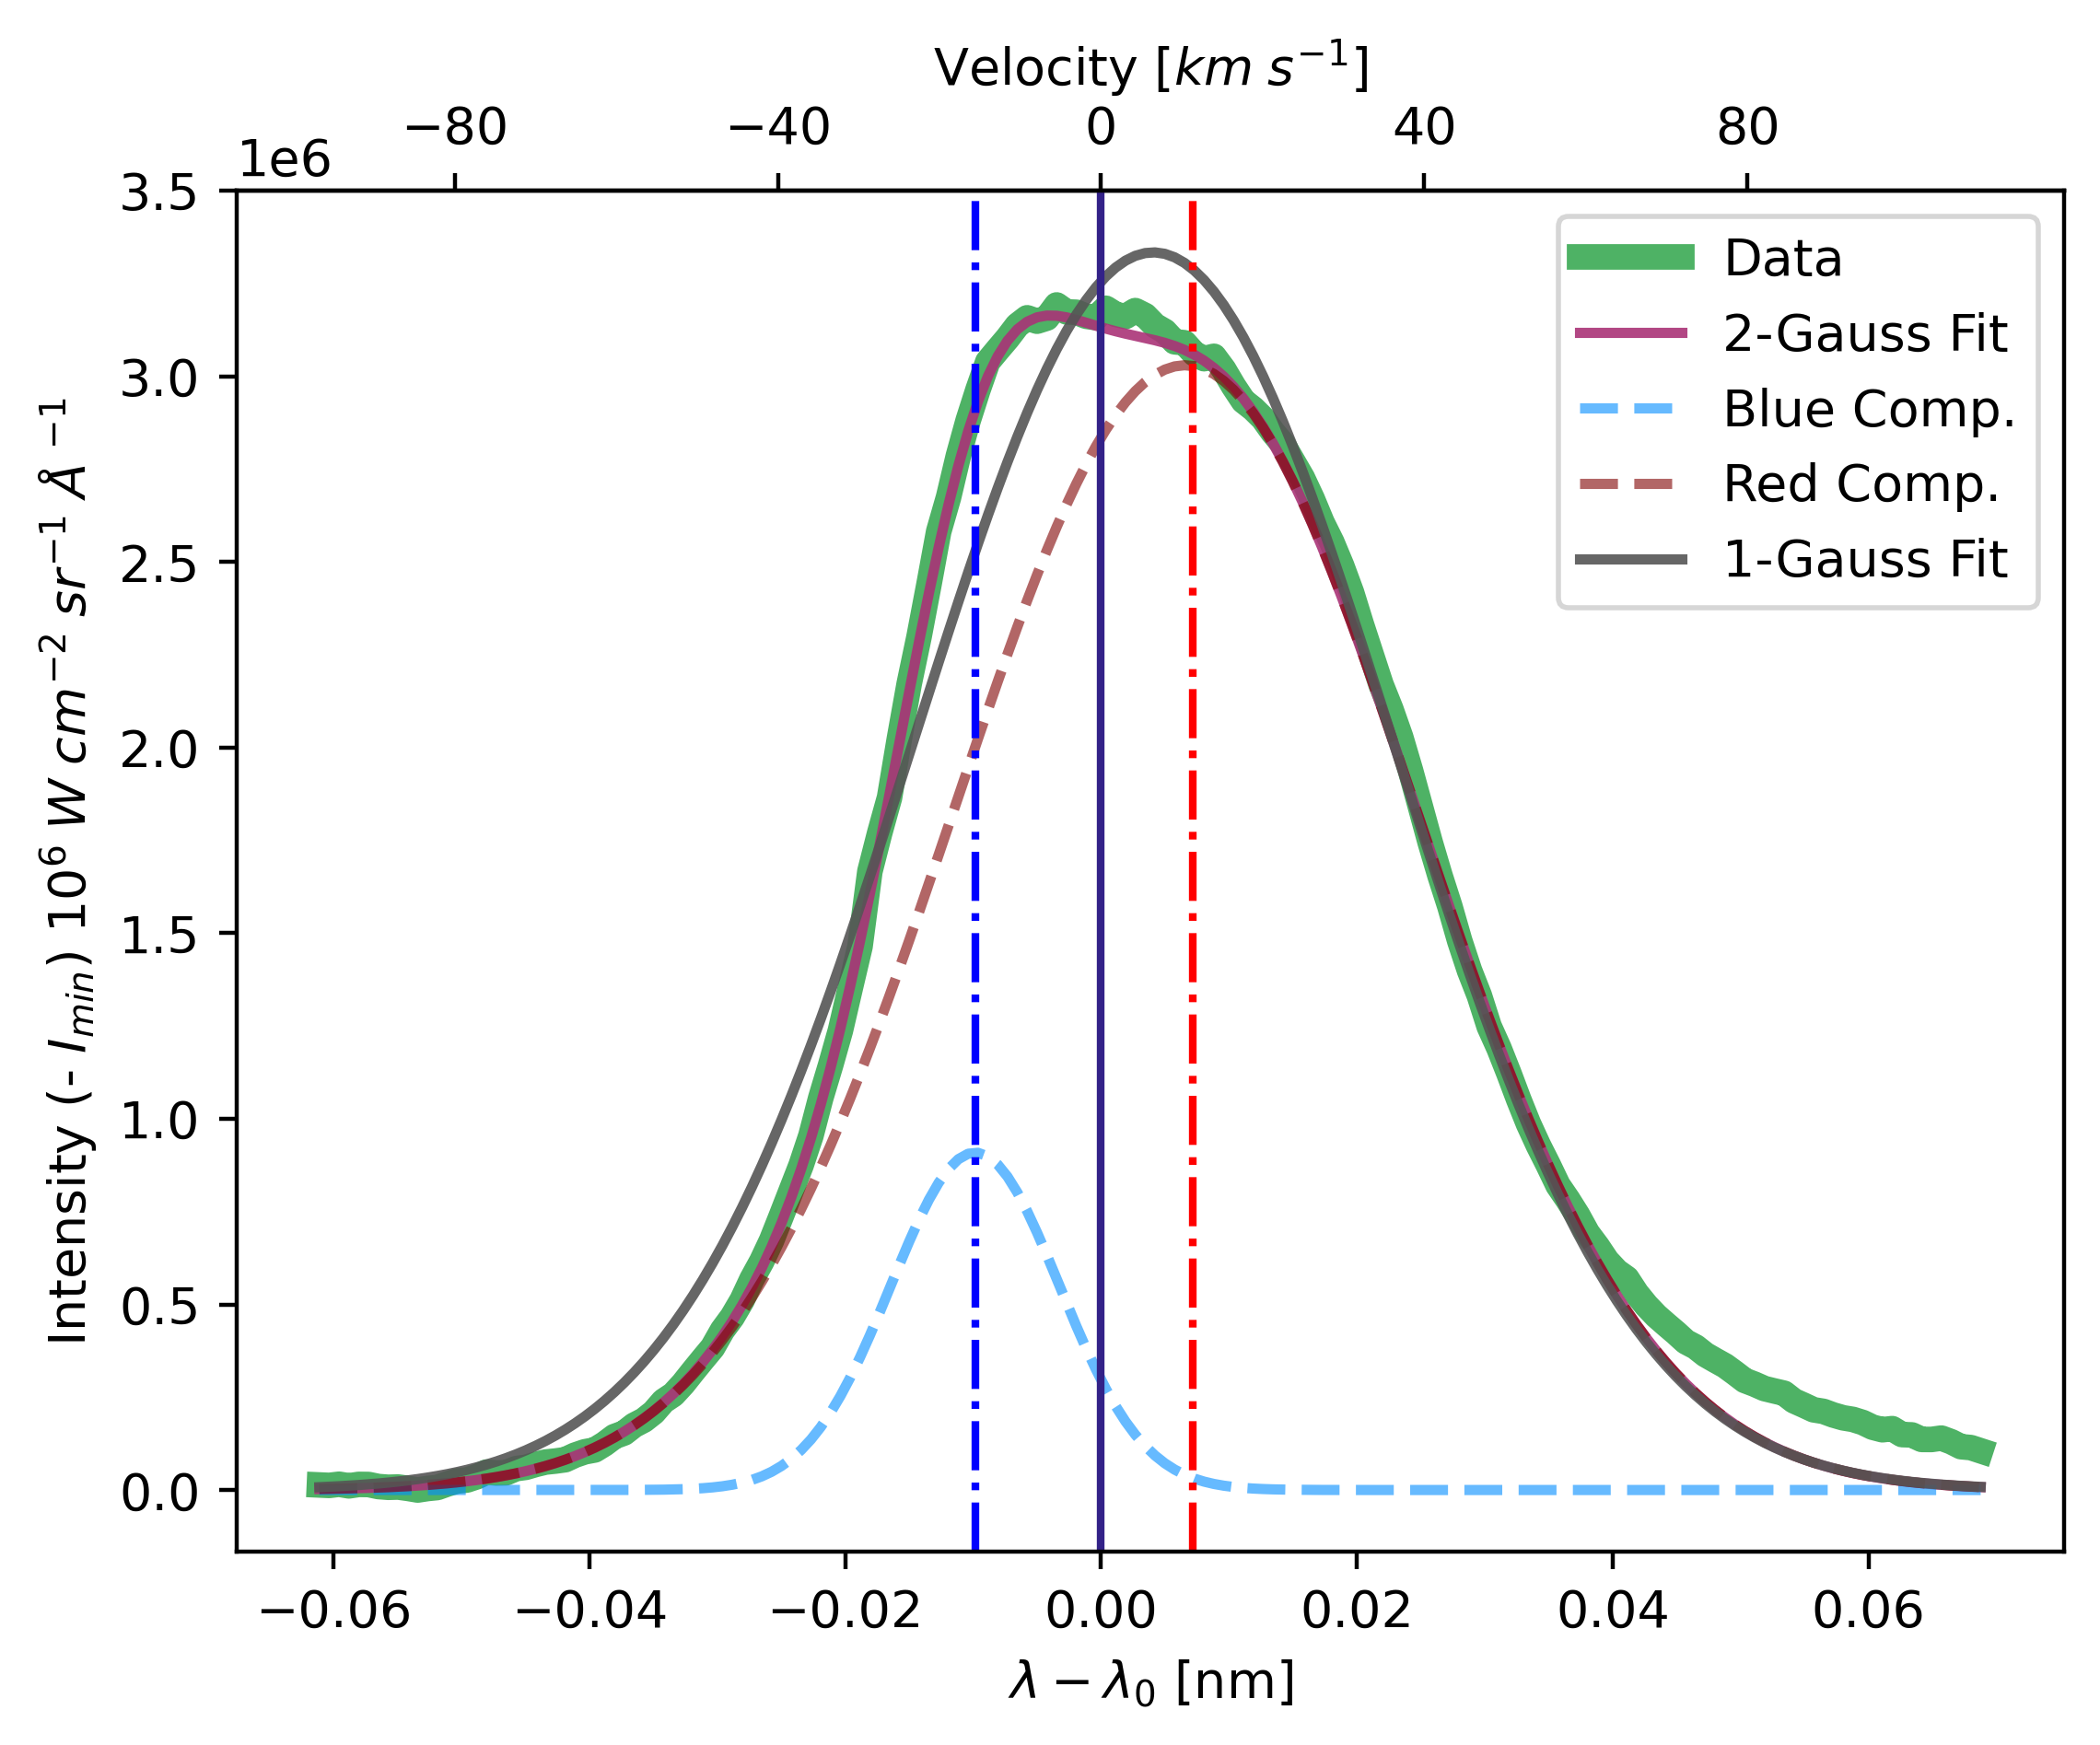

In [45]:
lamb0 = wl
c=2.99e5
def veltrans(x):
    return ((((x+lamb0)/lamb0)-1)*c)/mu
    #return ((((x+lamb0)/lamb0)-1)*c) #old, no mu angle difference

def wltrans(x):
    return ((((x/c)+1)*lamb0)-lamb0)
fig,ax=plt.subplots(dpi=400)
ax.plot(selwlshift,sels[10],color=cmap_choice[10],linewidth=5,label='Data')
ax.plot(selwlshift,gauss2fity,color='#AA3377',label='2-Gauss Fit',alpha = .9,linewidth=2)
ax.plot(selwlshift,comp1fity,'--',color=colors[5],label='Blue Comp.',alpha=0.6,linewidth=2)
ax.plot(selwlshift,comp2fity,'--',color=colors[19],label='Red Comp.',alpha=0.6,linewidth=2)
ax.plot(selwlshift,gauss1fit,color='#555555',label='1-Gauss Fit',alpha = .9,linewidth=2)
ax.grid(alpha=.5)
ax.set_xlabel(r'$\lambda - \lambda_0$ [nm]')
ax.set_ylabel(r'Intensity (- $I_{min}$) $10^6\; W\; cm^{-2}\; sr^{-1}\; \AA\; ^{-1}$')
ax.legend(loc='upper right')
secaxx = ax.secondary_xaxis('top', functions=(veltrans,wltrans))
secaxx.set_xlabel(r'Velocity $[km\; s^{-1}]$')
secaxx.set_xticks([-80,-40,0,40,80])
ax.grid()
ax.axvline(0,color='#332288')
ax.axvline(-.0098,color='blue',linestyle='-.')
ax.axvline(.0072,color='red',linestyle='-.')

#ax.set_ylabel('Proportion of line height')

[]

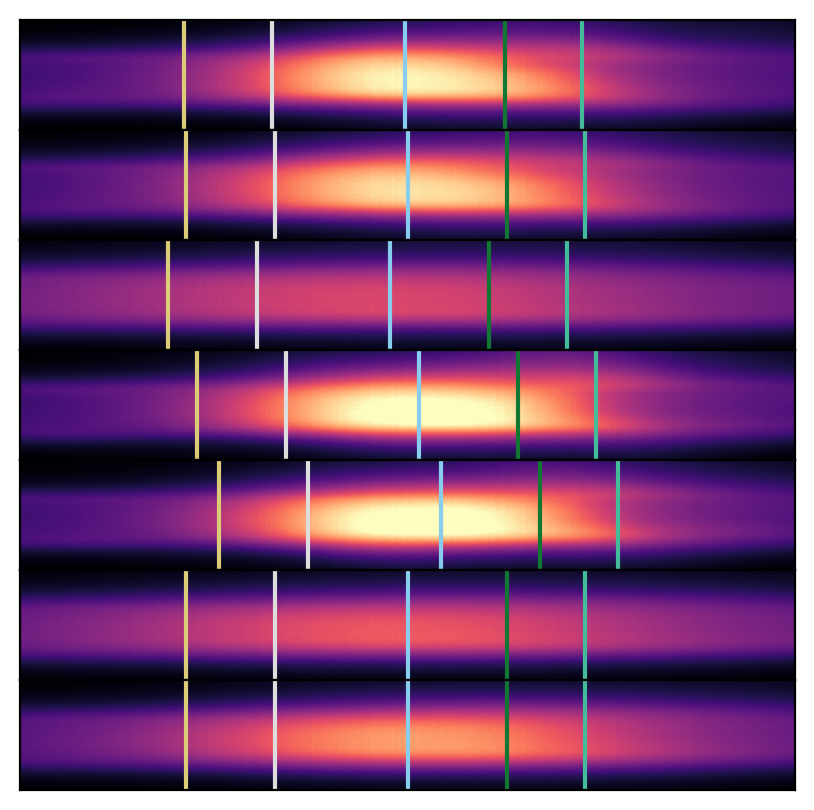

In [46]:
fig,ax=plt.subplots(7,1,figsize=(5,5),dpi=200)
ax[0].pcolormesh(X,Y,img1,vmin=mincbar,vmax=maxcbar,cmap='magma')
ax[1].pcolormesh(X,Y,img2,vmin=mincbar,vmax=maxcbar,cmap='magma')
ax[2].pcolormesh(X,Y,img3,vmin=mincbar,vmax=maxcbar,cmap='magma')
ax[3].pcolormesh(X,Y,img4,vmin=mincbar,vmax=maxcbar,cmap='magma')
ax[4].pcolormesh(X,Y,img5,vmin=mincbar,vmax=maxcbar,cmap='magma')
ax[5].pcolormesh(X,Y,img6,vmin=mincbar,vmax=maxcbar,cmap='magma')
ax[6].pcolormesh(X,Y,img7,vmin=mincbar,vmax=maxcbar,cmap='magma')
fig.subplots_adjust(wspace=0, hspace=0)

for i in range(7):
    ax[i].axvline(spatial_range[maxindices[[i]]],color='#88CCEE')
    
for i in range(7):
    ax[i].axvline(spatial_range[maxindices[[i]]-100],color='#DDCC77')
    
for i in range(7):
    ax[i].axvline(spatial_range[maxindices[[i]]-60],color='#DDDDDD')
    
for i in range(7):
    ax[i].axvline(spatial_range[maxindices[[i]]+45],color='#117733')
    
for i in range(7):
    ax[i].axvline(spatial_range[maxindices[[i]]+80],color='#44BB99')

ax[0].set_yticks([])
ax[1].set_yticks([])
ax[2].set_yticks([])
ax[3].set_yticks([])
ax[4].set_yticks([])
ax[5].set_yticks([])
ax[6].set_yticks([])

ax[0].set_xticks([])
ax[1].set_xticks([])
ax[2].set_xticks([])
ax[3].set_xticks([])
ax[4].set_xticks([])
ax[5].set_xticks([])
ax[6].set_xticks([])
                 

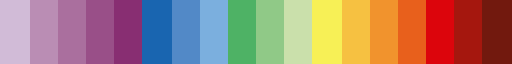

In [47]:
maps = tol_colors.TOLcmaps()
maps.get('rainbow_discrete',18)

[]

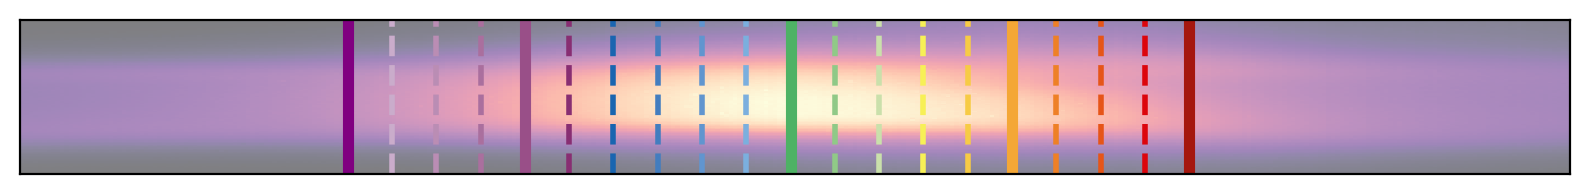

In [48]:
# just first time step
ncol = 20
map = tol_colors.tol_cmap(colormap='rainbow_discrete',lut=ncol+4)
cmap_choice = map(np.linspace(0,1,ncol+2))
fig,ax=plt.subplots(figsize=(10,1),dpi=200)
ax.pcolormesh(X,Y,img1,vmin=mincbar,vmax=maxcbar,cmap='magma',alpha=.5)
fig.subplots_adjust(wspace=0, hspace=0)

for i in range(ncol):
    if i == 0:
        ax.axvline(spatial_range[maxindices[[0]]-100+(i*10)],color='purple',linewidth=4,alpha=1)
    elif i == 4 or i==10 or i == 15 or i == 19:
        ax.axvline(spatial_range[maxindices[[0]]-100+(i*10)],color=cmap_choice[i],linewidth=4,alpha=1)
    else:
        ax.axvline(spatial_range[maxindices[[0]]-100+(i*10)],linestyle='--',color=cmap_choice[i],linewidth=2,alpha=1)

ax.set_yticks([])
ax.set_xticks([])

                 

[]

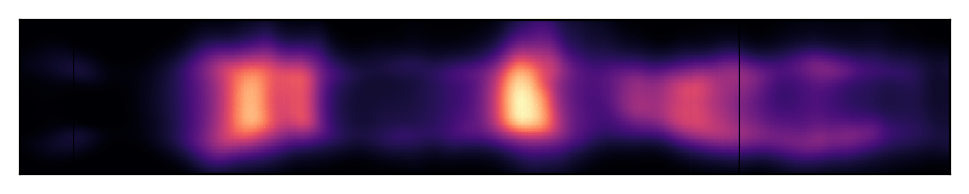

In [49]:
fig,ax=plt.subplots(figsize=(6,1),dpi=200)
ax.pcolormesh(bkgd_subtract_flaretime[0,510:620,:],vmin=mincbar,vmax=maxcbar,cmap='magma')
ax.set_xticks([])
ax.set_yticks([])

In [50]:
mu =  0.4760111410077789
vel1_on,vel2_on = conv_to_vel(storemu1_2_on,storemu2_2_on,mu)

maxindex_frame1 = maxindices[0]
indices = np.arange(maxindex_frame1-100,maxindex_frame1+100,10)
frame1 = bkgd_subtract_flaretime[0,:,:]

frame1 = np.expand_dims(frame1, axis=0)

caII_low = 480
caII_high = 650
hep_low = 700
hep_high = 850
wl = 396.847 # central wavelength, Ca II H

In [51]:
sels=[]

for i in range(len(indices)):
    sliceind = indices[i]
    sel = frame1[0,caII_low:caII_high,sliceind]-\
        min(frame1[0,caII_low:caII_high,sliceind])
    selwl = dispersion_range_fin_on[caII_low:caII_high]
    sels.append(sel)

In [52]:
indices

array([1273, 1283, 1293, 1303, 1313, 1323, 1333, 1343, 1353, 1363, 1373,
       1383, 1393, 1403, 1413, 1423, 1433, 1443, 1453, 1463])

Text(0.5, 0, 'Velocity $[km\\; s^{-1}]$')

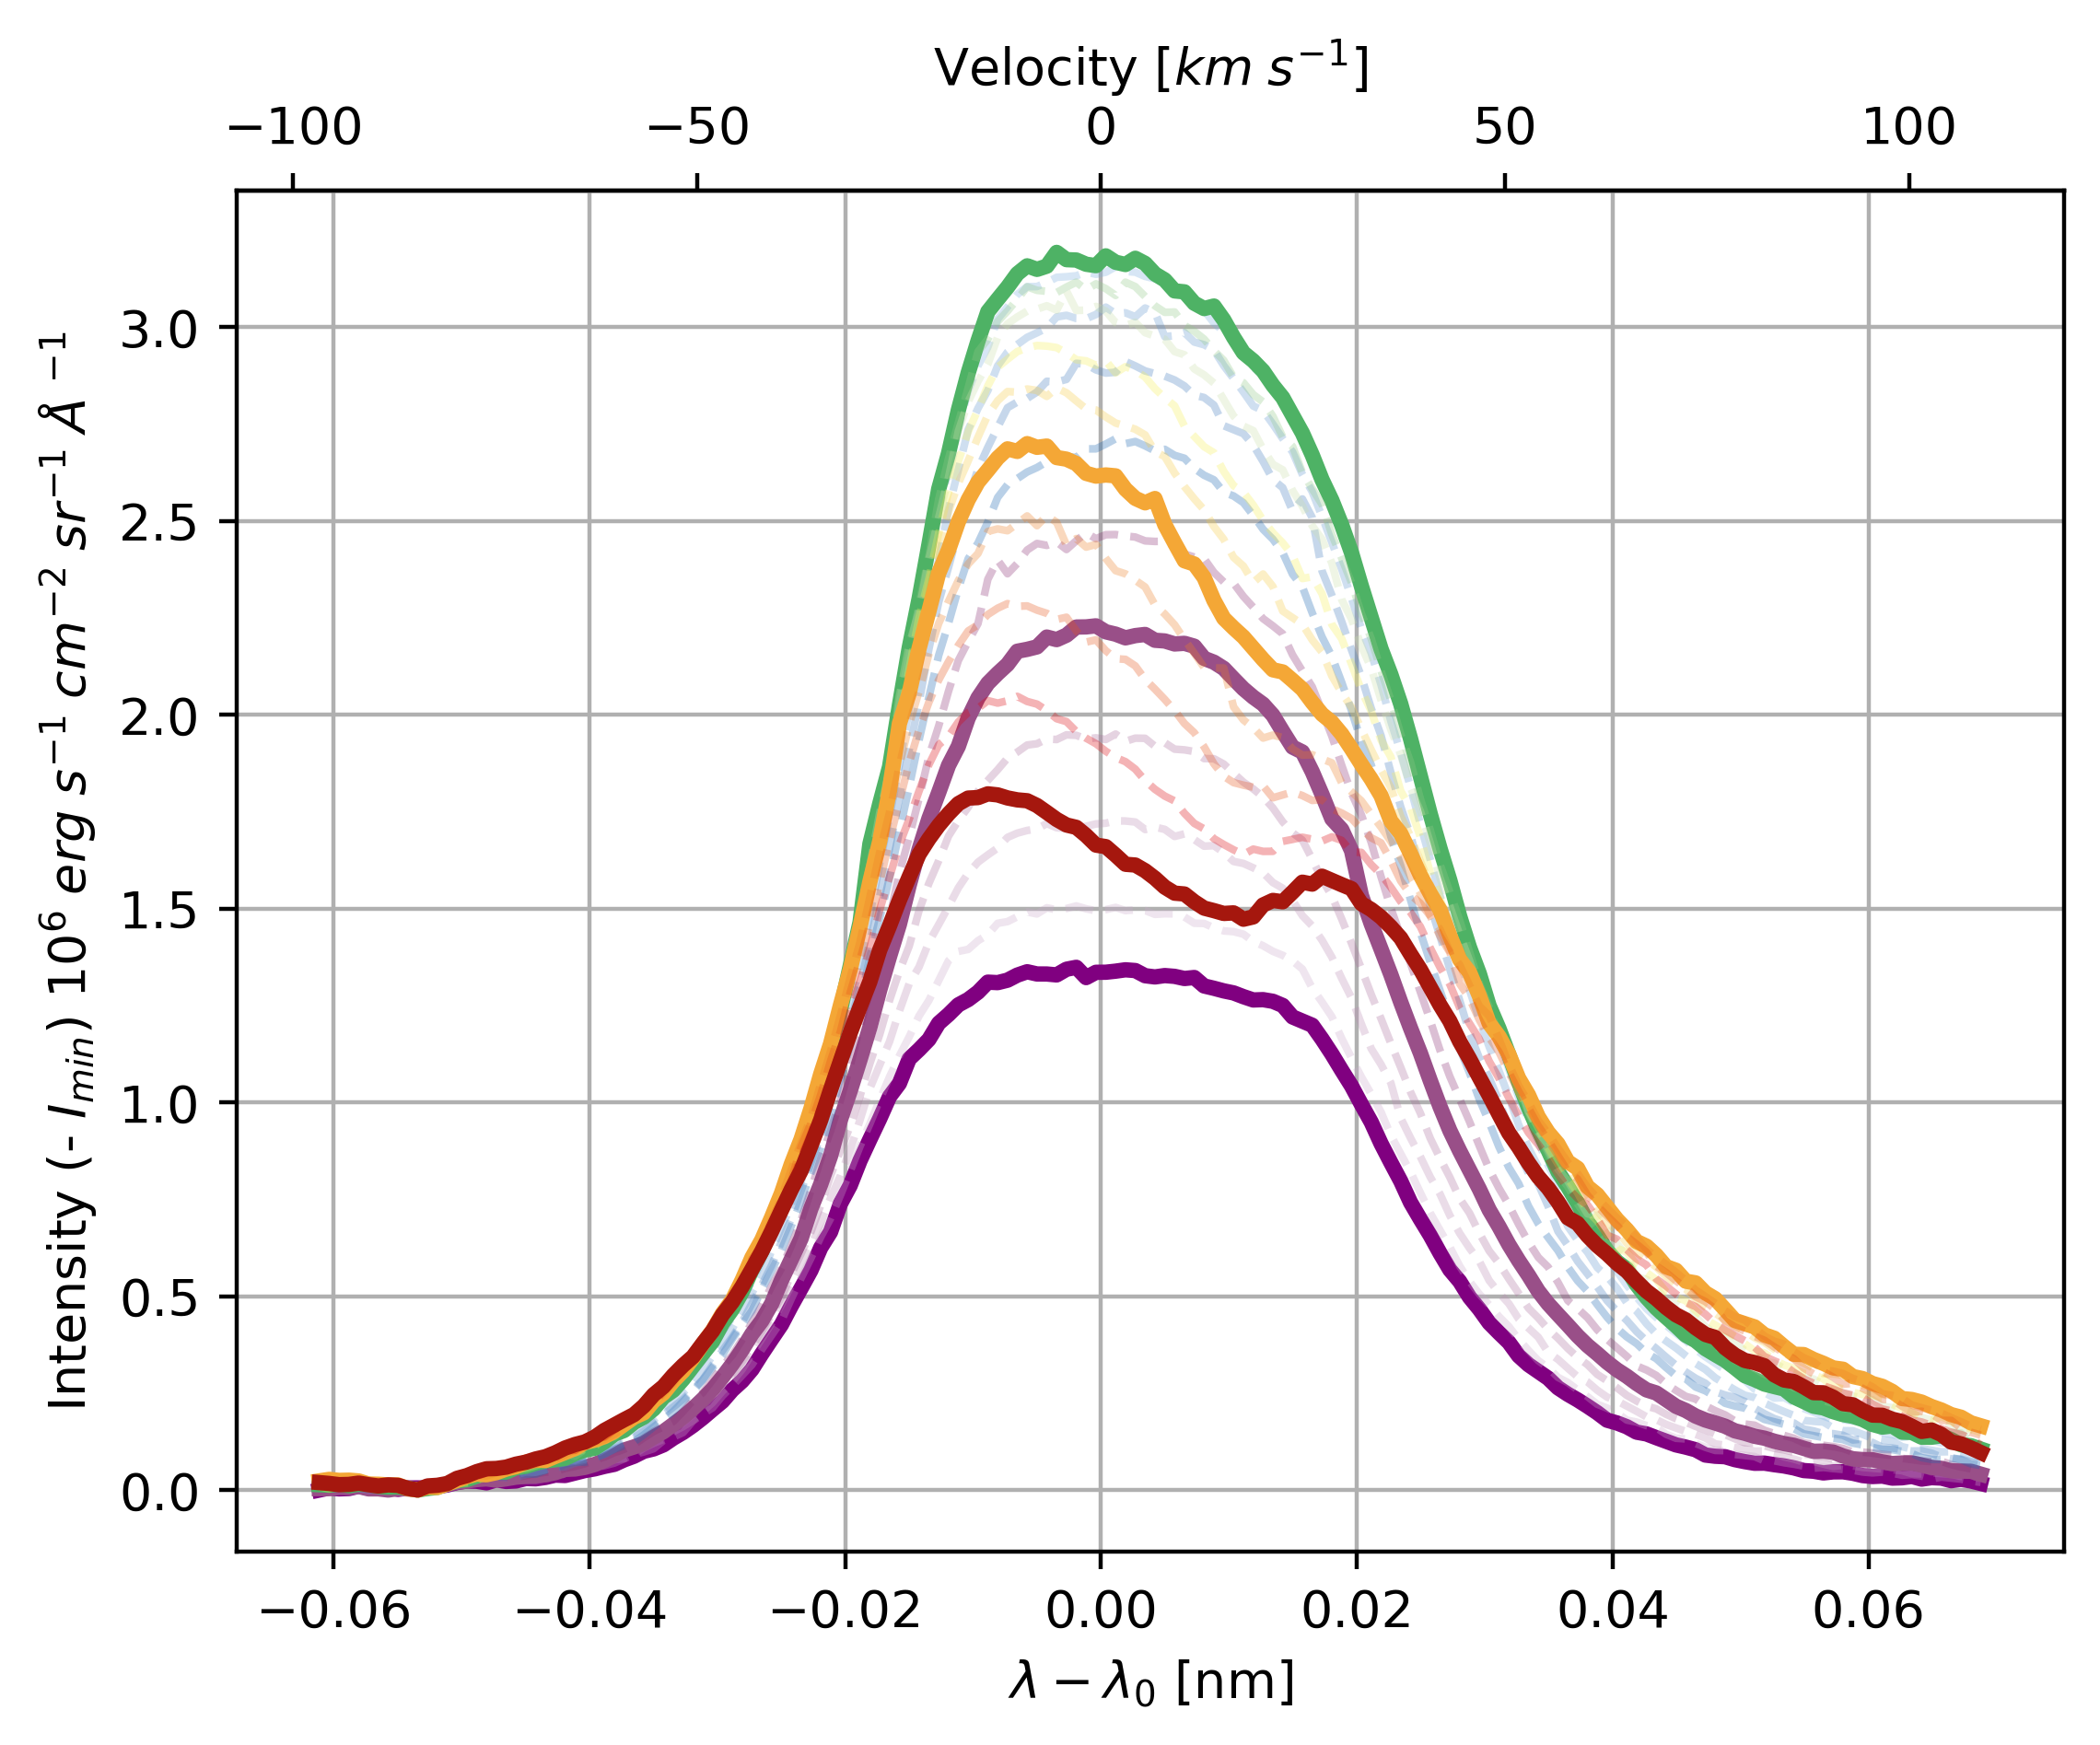

In [53]:
n = 20
colors = plt.cm.jet(np.linspace(0,1,n))

fig,ax=plt.subplots(dpi=400)
for i in range(n):
    if i == 0:
        ax.plot(selwlshift,sels[i]/1e6,color='purple',linewidth=3)
    elif i == 4 or i==10 or i == 15 or i == 19:
        ax.plot(selwlshift,sels[i]/1e6,color=cmap_choice[i],linewidth=3)
    else:
        ax.plot(selwlshift,sels[i]/1e6,color=cmap_choice[i],alpha=.3,linestyle='--')

ax.grid()
ax.set_xlabel(r'$\lambda - \lambda_0$ [nm]')
ax.set_ylabel(r'Intensity (- $I_{min}$) $10^6\; erg\;s^{-1}\; cm^{-2}\; sr^{-1}\; \AA\; ^{-1}$')
#ax.set_title('Ca II H flare-time emission across flare ribbon')
secaxx = ax.secondary_xaxis('top', functions=(veltrans,wltrans))
secaxx.set_xlabel(r'Velocity $[km\; s^{-1}]$')
#ax.annotate('Violet - leading edge\nYellow - trailing edge',[396.88,4e6])

In [54]:
leftindss = []
rightindss = []
levss = []
centroidss = []
centroidss0 = []
widths = []
widths0 = []
sels_scp =sels
#generalize
for i in range(len(sels)):
    forcentroids = sels_scp[i]
    minval = min(forcentroids)
    maxval = max(forcentroids)
    levs = np.linspace(minval,maxval,11)
    
    levss.append(levs)
    
    leftinds = []
    rightinds = []
    leftvals = []
    rightvals = []

    for j in levs:
        leftval,leftind = find_nearest(forcentroids[0:round(len(forcentroids)/2)],j)
        rightval,rightind0 = find_nearest(forcentroids[round(len(forcentroids)/2):],j)
        rightind = round(len(forcentroids)/2)+rightind0

        leftinds.append(leftind)
        rightinds.append(rightind)

        leftvals.append(leftval)
        rightvals.append(rightval)
    
    leftindss.append(leftinds)
    rightindss.append(rightinds)
    
    rightwls = selwl[rightinds]
    leftwls = selwl[leftinds]
    centroids = []
    centroids0 = []

    for j in range(len(rightwls)):
        rightwl = rightwls[j]
        leftwl = leftwls[j]
        centroids.append(np.mean([rightwl,leftwl]))
        centroids0.append(np.mean([rightwl,leftwl])-wl)
        

    centroidss.append(centroids)
    centroidss0.append(centroids0)


In [55]:
leftwls = selwl[leftindss]
rightwls = selwl[rightindss]

In [56]:
widths = np.subtract(rightwls,leftwls)
np.shape(widths)

(20, 11)

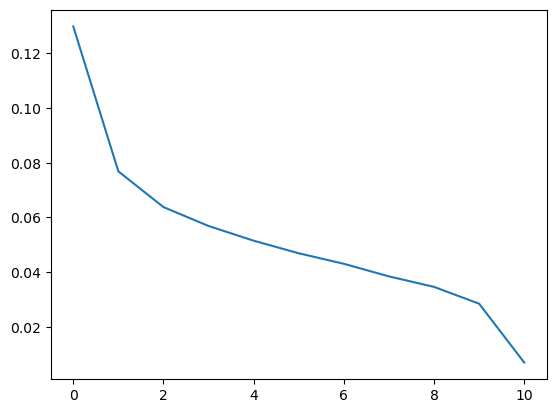

In [57]:
plt.plot(range(len(widths[0])),widths[0])

In [101]:
normlevss = []
for i in range(len(levss)):
    levs = levss[i]
    normlevss.append(preprocessing.normalize([levs]))

In [102]:
normlevss

[array([[0.        , 0.05096472, 0.10192944, 0.15289416, 0.20385888,
         0.2548236 , 0.30578831, 0.35675303, 0.40771775, 0.45868247,
         0.50964719]]),
 array([[0.        , 0.05096472, 0.10192944, 0.15289416, 0.20385888,
         0.2548236 , 0.30578831, 0.35675303, 0.40771775, 0.45868247,
         0.50964719]]),
 array([[0.        , 0.05096472, 0.10192944, 0.15289416, 0.20385888,
         0.2548236 , 0.30578831, 0.35675303, 0.40771775, 0.45868247,
         0.50964719]]),
 array([[0.        , 0.05096472, 0.10192944, 0.15289416, 0.20385888,
         0.2548236 , 0.30578831, 0.35675303, 0.40771775, 0.45868247,
         0.50964719]]),
 array([[0.        , 0.05096472, 0.10192944, 0.15289416, 0.20385888,
         0.2548236 , 0.30578831, 0.35675303, 0.40771775, 0.45868247,
         0.50964719]]),
 array([[0.        , 0.05096472, 0.10192944, 0.15289416, 0.20385888,
         0.2548236 , 0.30578831, 0.35675303, 0.40771775, 0.45868247,
         0.50964719]]),
 array([[0.        , 0.05096

In [59]:
    if i == 0:
        ax.plot(selwl,sels[i]/1e6,color='purple',linewidth=3)
    elif i == 4 or i==10 or i == 15 or i == 19:
        ax.plot(selwl,sels[i]/1e6,color=cmap_choice[i],linewidth=3)
    else:
        ax.plot(selwl,sels[i]/1e6,color=cmap_choice[i],alpha=.3,linestyle='--')

Text(0, 0.5, 'Proportion of line height')

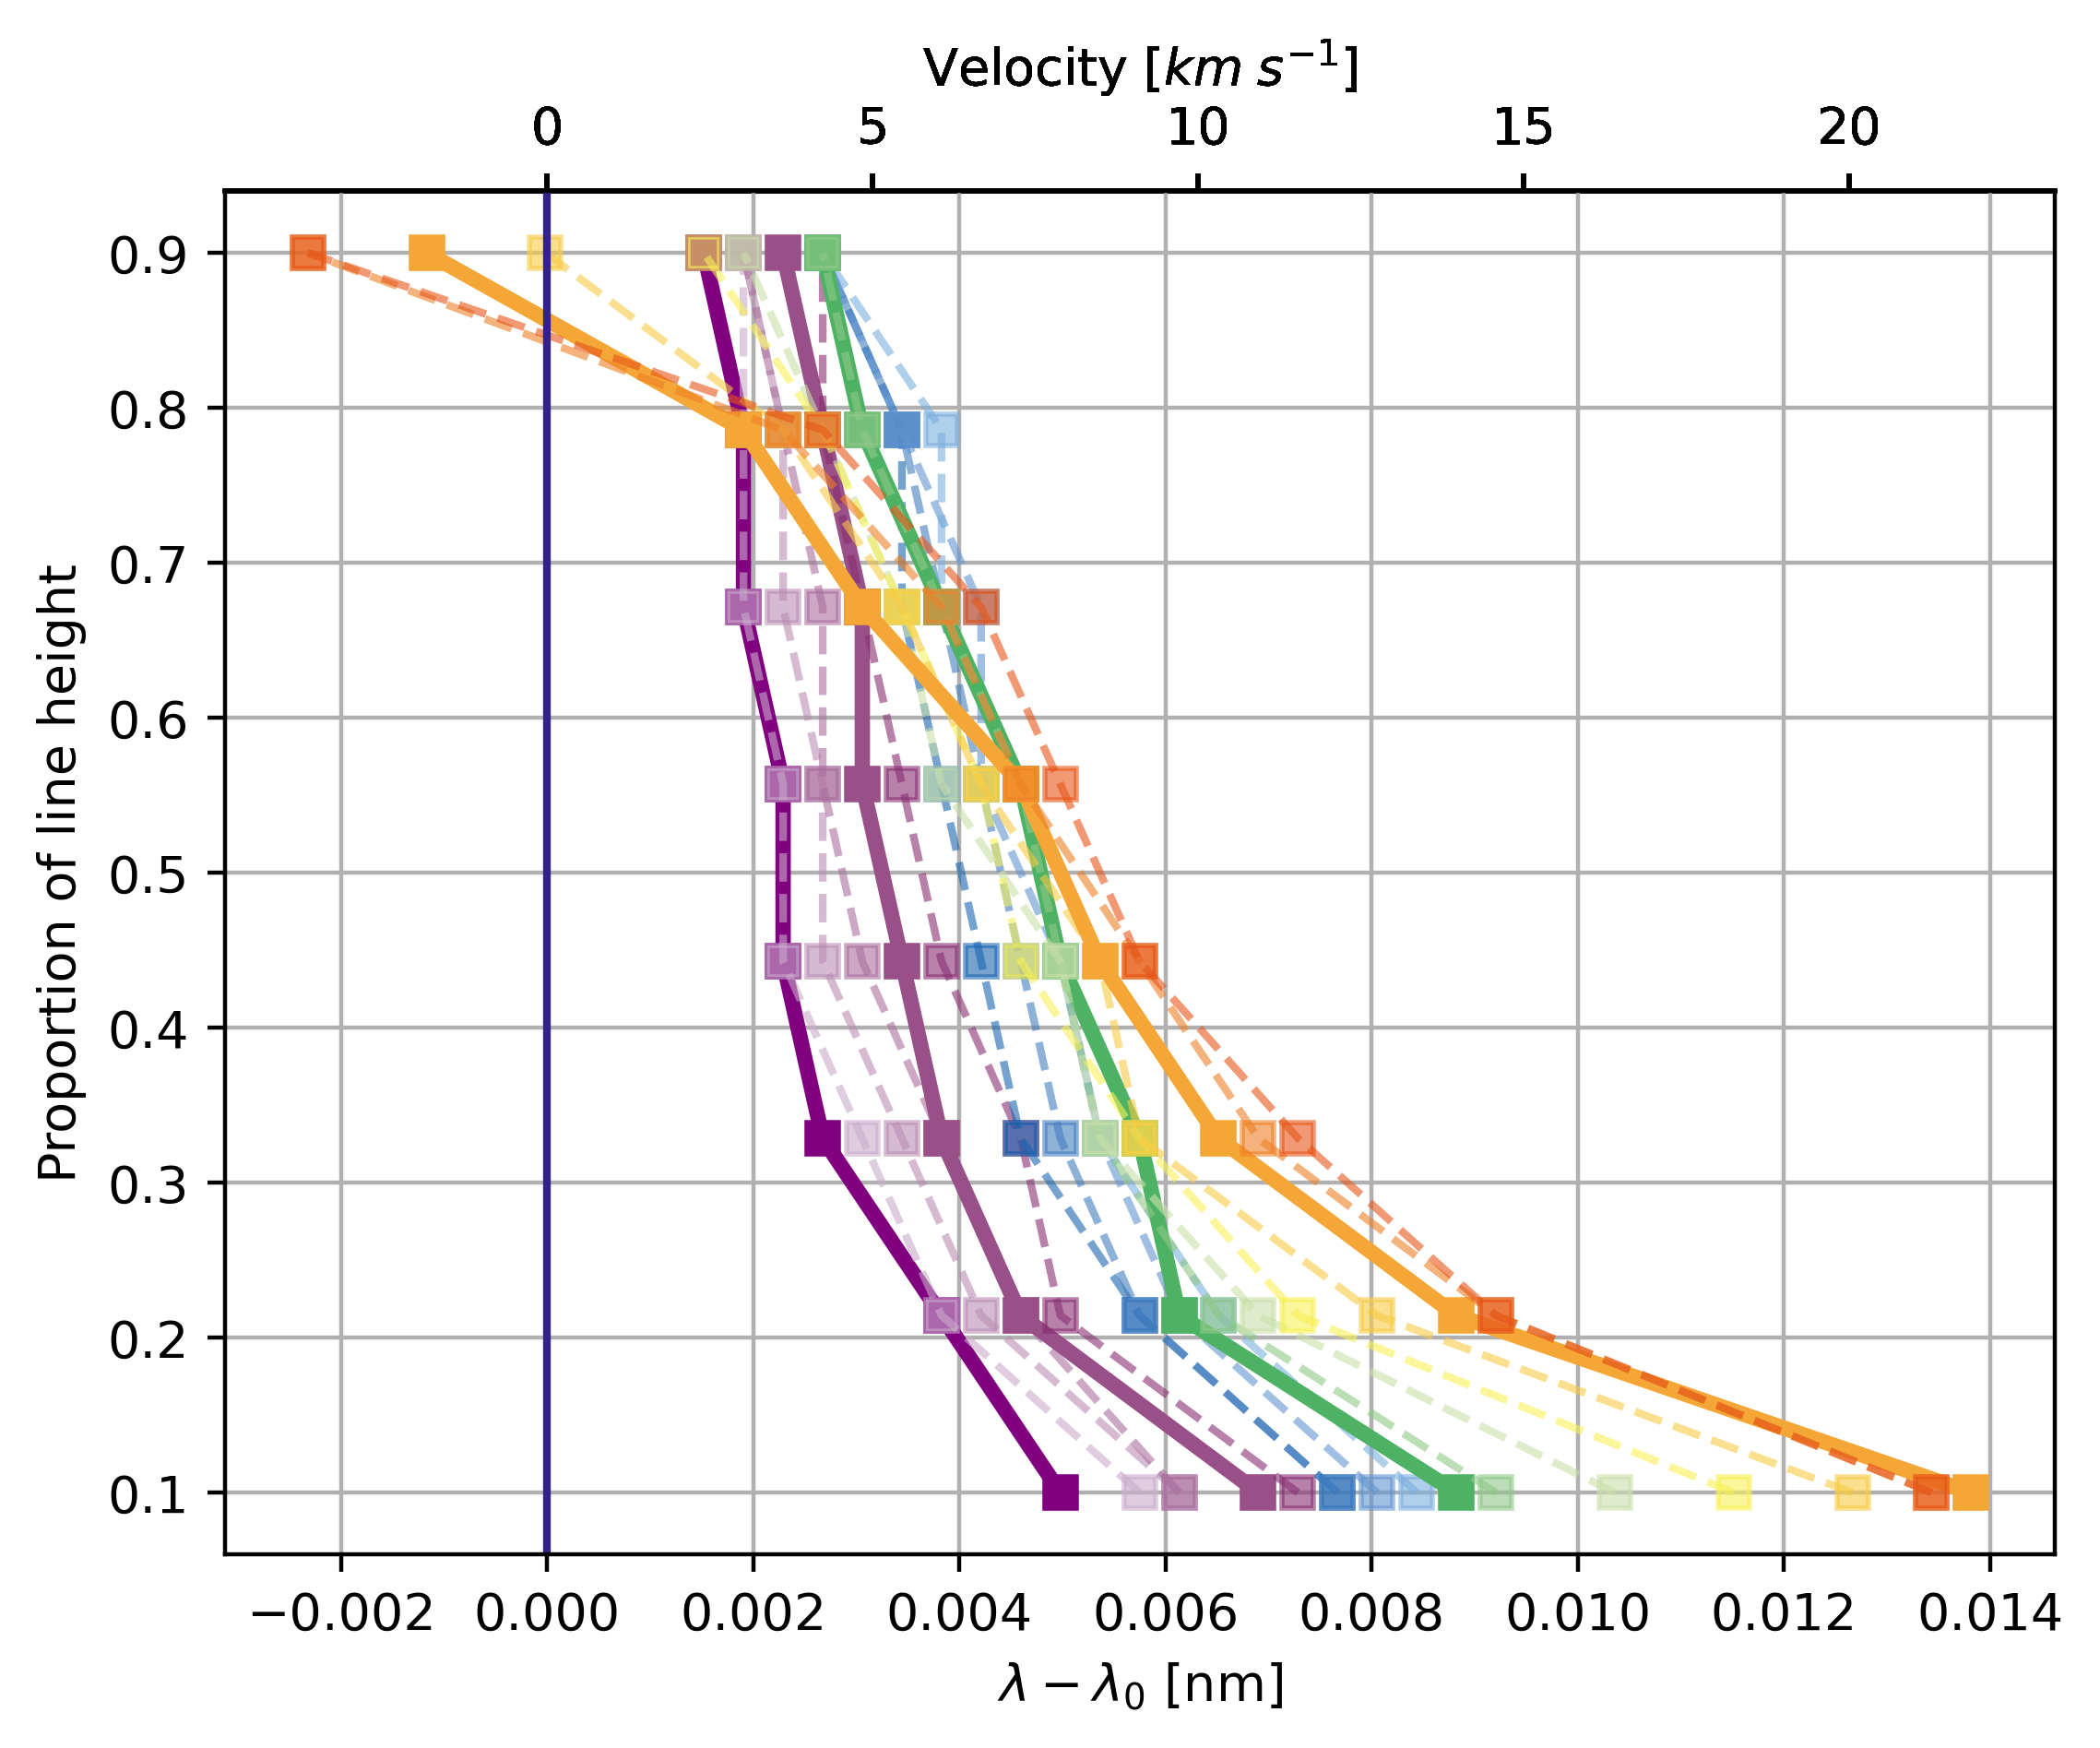

In [60]:
fig,ax=plt.subplots(dpi=400)

lamb0 = wl
c=2.99e5
def veltrans(x):
    return ((((x+lamb0)/lamb0)-1)*c)/mu
    #return ((((x+lamb0)/lamb0)-1)*c) #old, no mu angle difference

def wltrans(x):
    return ((((x/c)+1)*lamb0)-lamb0)


for i in range(18):
    if i == 0:
        ax.plot(centroidss0[i][1:-2],np.linspace(.1,.9,8),marker='s',color='purple',linewidth=3)
    elif i == 4 or i==10 or i == 15 or i == 19:
        ax.plot(centroidss0[i][1:-2],np.linspace(.1,.9,8),marker='s',color=cmap_choice[i],linewidth=3)
    else:
        ax.plot(centroidss0[i][1:-2],np.linspace(.1,.9,8),marker='s',color=cmap_choice[i],linestyle='--',alpha=.6)
    secaxx = ax.secondary_xaxis('top', functions=(veltrans,wltrans))
    secaxx.set_xlabel(r'Velocity $[km\; s^{-1}]$')
ax.grid()
ax.axvline(0,color='#332288')
ax.set_xlabel(r'$\lambda - \lambda_0$ [nm]')
ax.set_ylabel('Proportion of line height')


Text(0, 0.5, 'Proportion of line height')

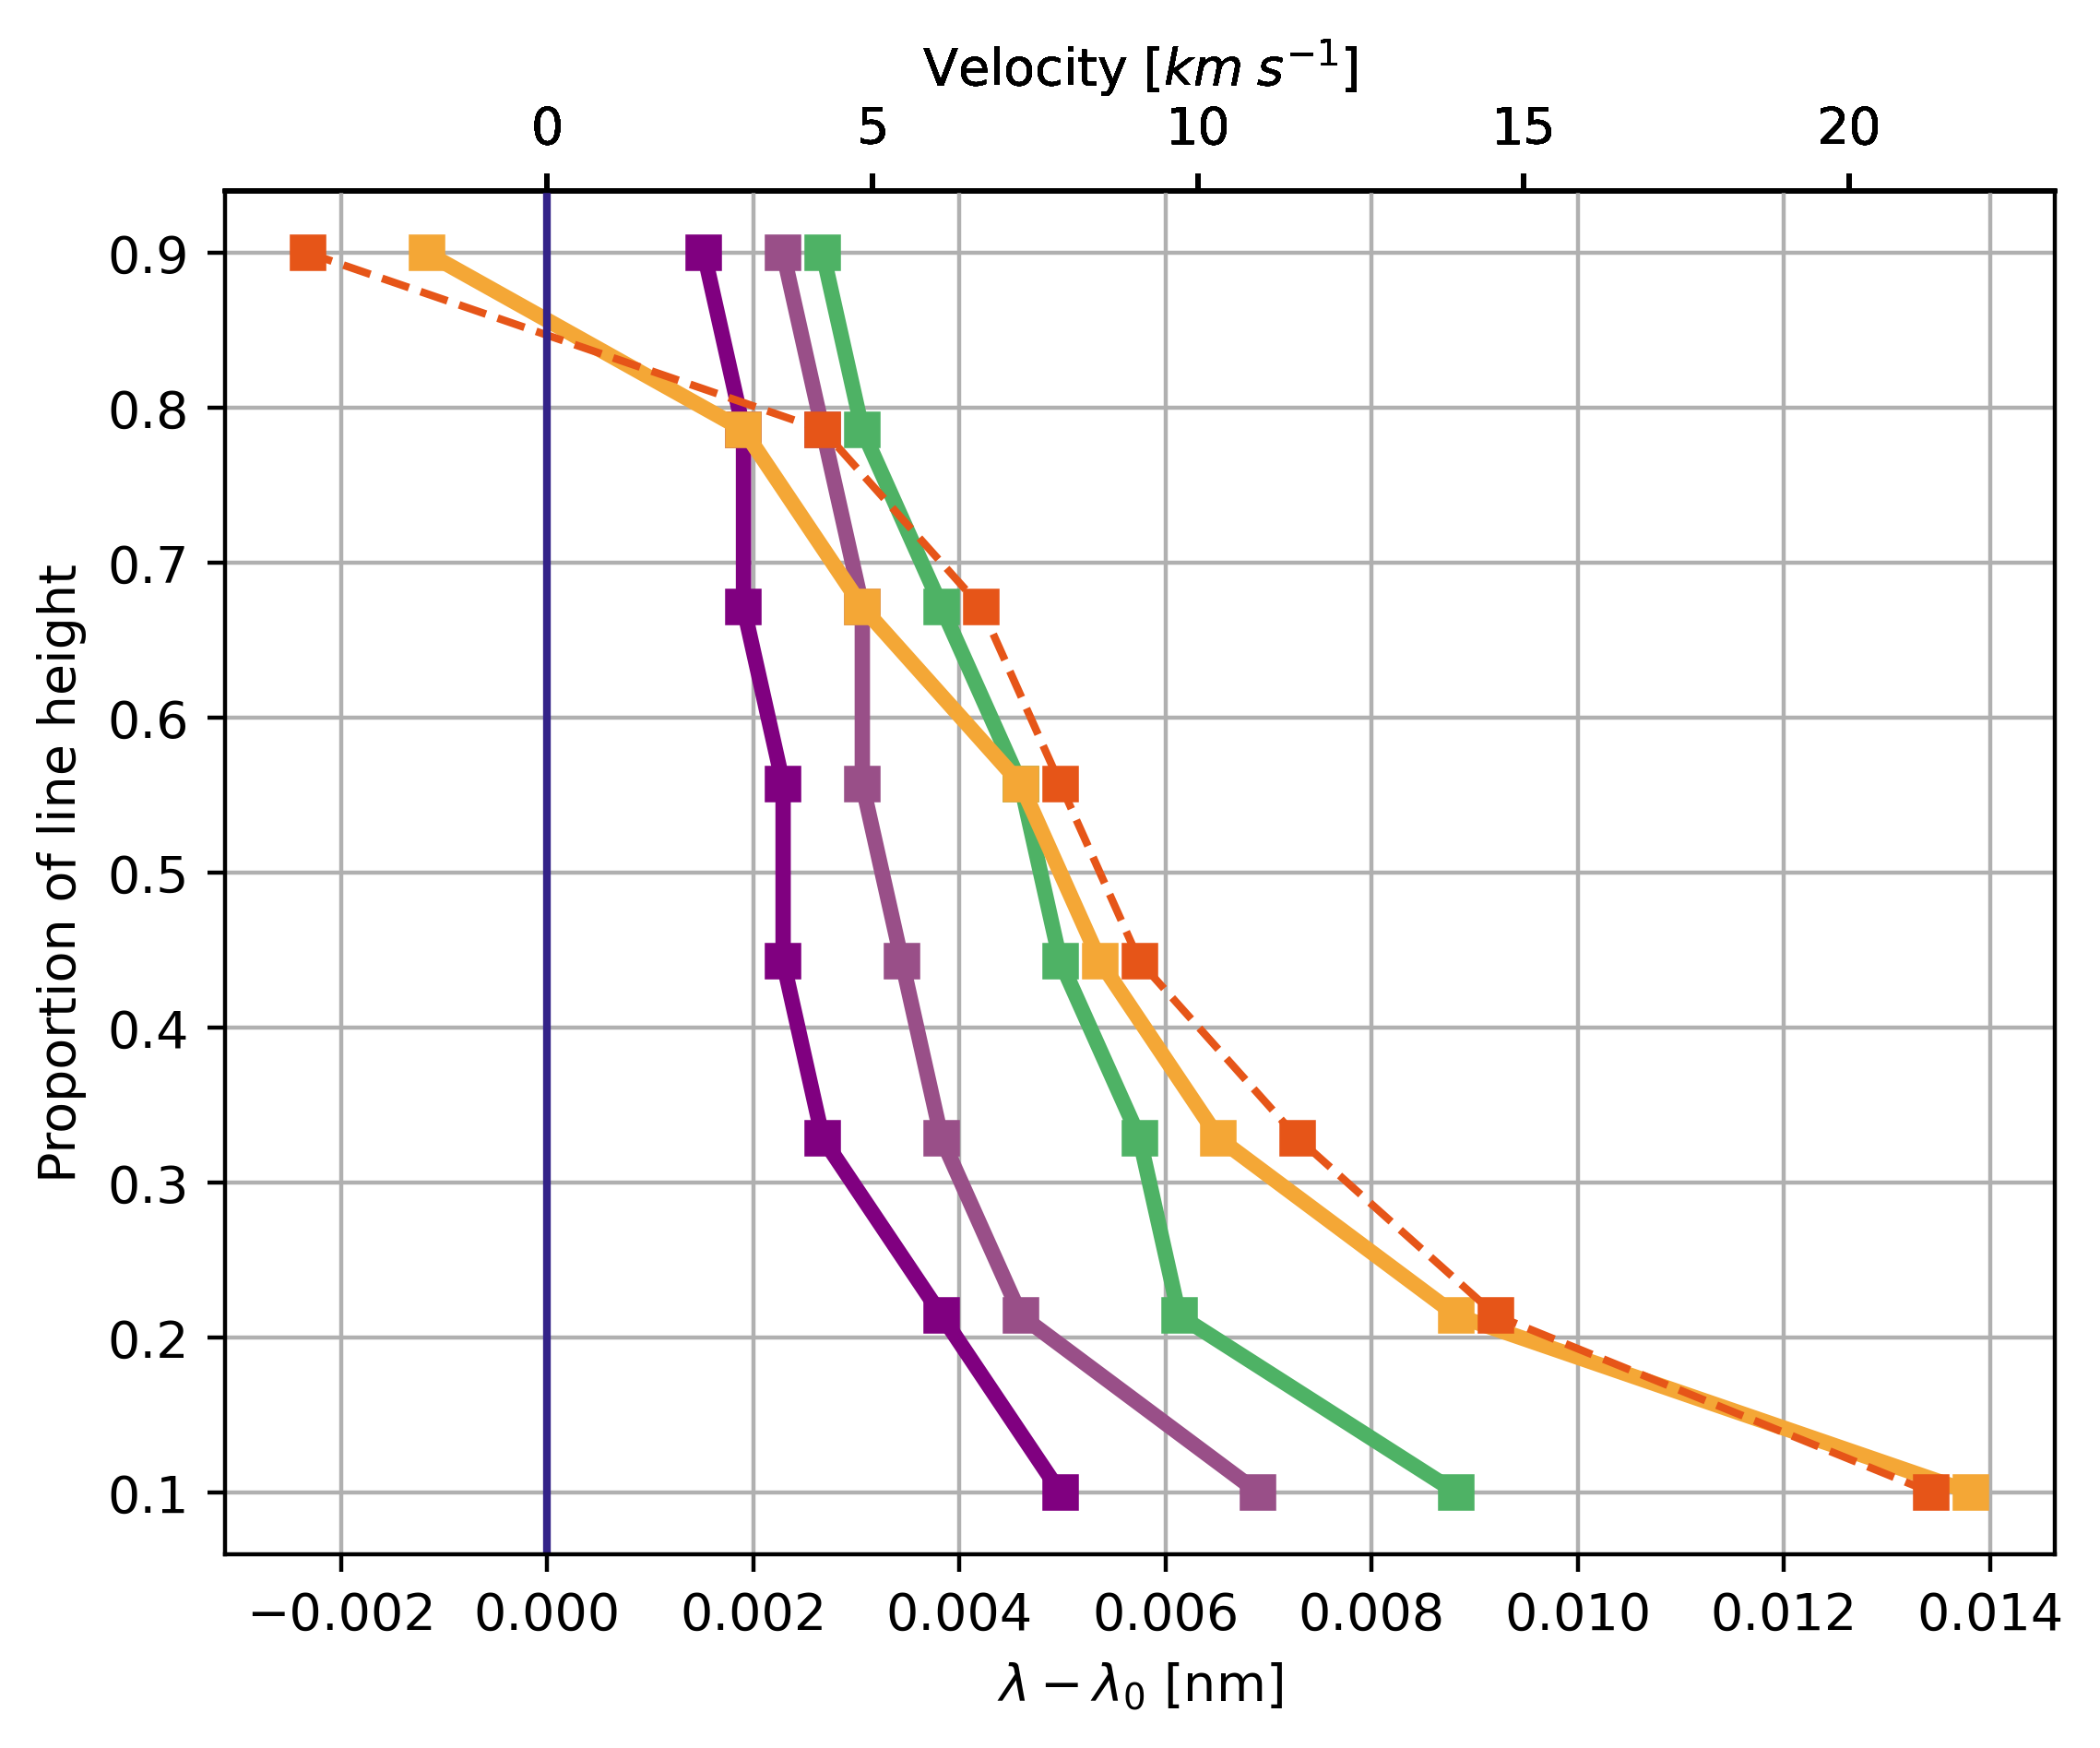

In [61]:
fig,ax=plt.subplots(dpi=400)

lamb0 = wl
c=2.99e5
def veltrans(x):
    return ((((x+lamb0)/lamb0)-1)*c)/mu
    #return ((((x+lamb0)/lamb0)-1)*c) #old, no mu angle difference

def wltrans(x):
    return ((((x/c)+1)*lamb0)-lamb0)


for i in range(18):
    if i == 0:
        ax.plot(centroidss0[i][1:-2],np.linspace(.1,.9,8),marker='s',color='purple',linewidth=3)
    elif i == 4 or i==10 or i == 15:
        ax.plot(centroidss0[i][1:-2],np.linspace(.1,.9,8),marker='s',color=cmap_choice[i],linewidth=3)
    elif i == 17:
        ax.plot(centroidss0[i][1:-2],np.linspace(.1,.9,8),marker='s',color=cmap_choice[i],linestyle='--',alpha=1)
    secaxx = ax.secondary_xaxis('top', functions=(veltrans,wltrans))
    secaxx.set_xlabel(r'Velocity $[km\; s^{-1}]$')
ax.grid()
ax.axvline(0,color='#332288')
ax.set_xlabel(r'$\lambda - \lambda_0$ [nm]')
ax.set_ylabel('Proportion of line height')

Text(0, 0.5, 'Proportion of line height')

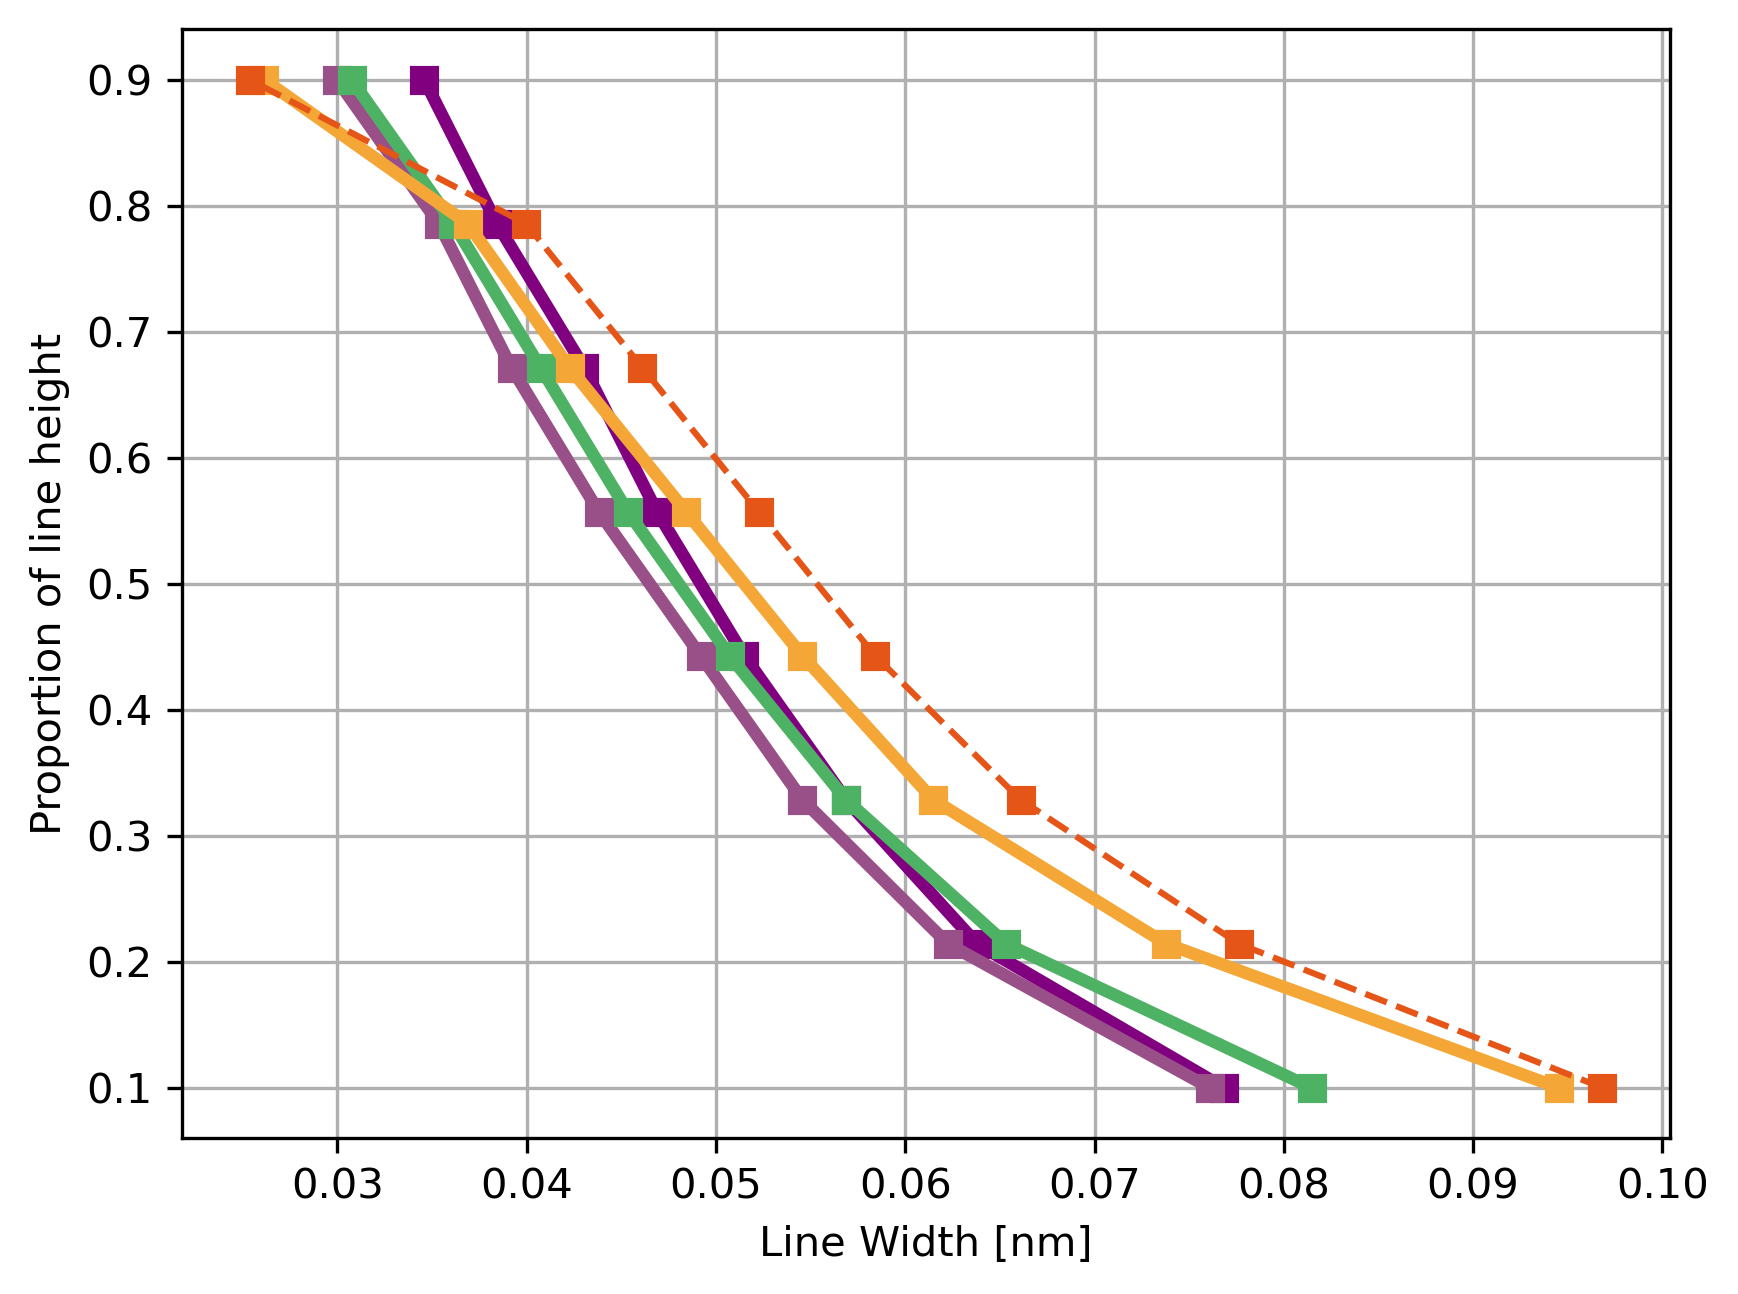

In [62]:
fig,ax=plt.subplots(dpi=300)

lamb0 = wl
c=2.99e5
def veltrans(x):
    return ((((x+lamb0)/lamb0)-1)*c)/mu
    #return ((((x+lamb0)/lamb0)-1)*c) #old, no mu angle difference

def wltrans(x):
    return ((((x/c)+1)*lamb0)-lamb0)


for i in range(18):
    if i == 0:
        ax.plot(widths[i][1:-2],np.linspace(.1,.9,8),marker='s',color='purple',linewidth=3)
    elif i == 4 or i==10 or i == 15:
        ax.plot(widths[i][1:-2],np.linspace(.1,.9,8),marker='s',color=cmap_choice[i],linewidth=3)
    elif i == 17:
        ax.plot(widths[i][1:-2],np.linspace(.1,.9,8),marker='s',color=cmap_choice[i],linestyle='--',alpha=1)

    # else:
    #     ax.plot(widths[i][1:-2],np.linspace(.1,.9,8),marker='s',color=cmap_choice[i],linestyle='--',alpha=.8)
    # secaxx = ax.secondary_xaxis('top', functions=(veltrans,wltrans))
    # secaxx.set_xlabel(r'Line Width $[nm]$')
ax.grid()
secaxx.set_xlabel(r'Velocity $[km\; s^{-1}]$')
ax.set_xlabel(r'Line Width [nm]')
ax.set_ylabel('Proportion of line height')

In [63]:
veltrans(centroidss0[i][3])

np.float64(11.531051447177868)

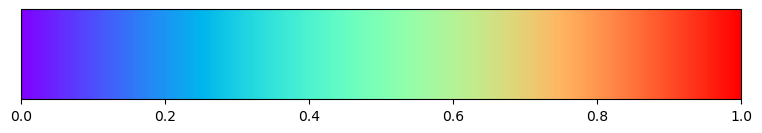

In [64]:
a = np.array([[0,1]])
plt.figure(figsize=(9, 1.5))
img = plt.imshow(a, cmap="rainbow")
plt.gca().set_visible(False)
cax = plt.axes([0.1, 0.2, 0.8, 0.6])
plt.colorbar(orientation="horizontal", cax=cax)

In [85]:
# same but for H-epsilon
selwl_hep = dispersion_range_fin_on[hep_low:hep_high]
selwlshift_hep=selwl_hep-lamb1


In [86]:
sels_hep=[]

for i in range(len(indices)):
    sliceind = indices[i]
    sel = frame1[0,hep_low:hep_high,sliceind]-\
        min(frame1[0,hep_low:hep_high,sliceind])
    selwl_hep = dispersion_range_fin_on[hep_low:hep_high]
    sels_hep.append(sel)

Text(0.5, 0, 'Velocity $[km\\; s^{-1}]$')

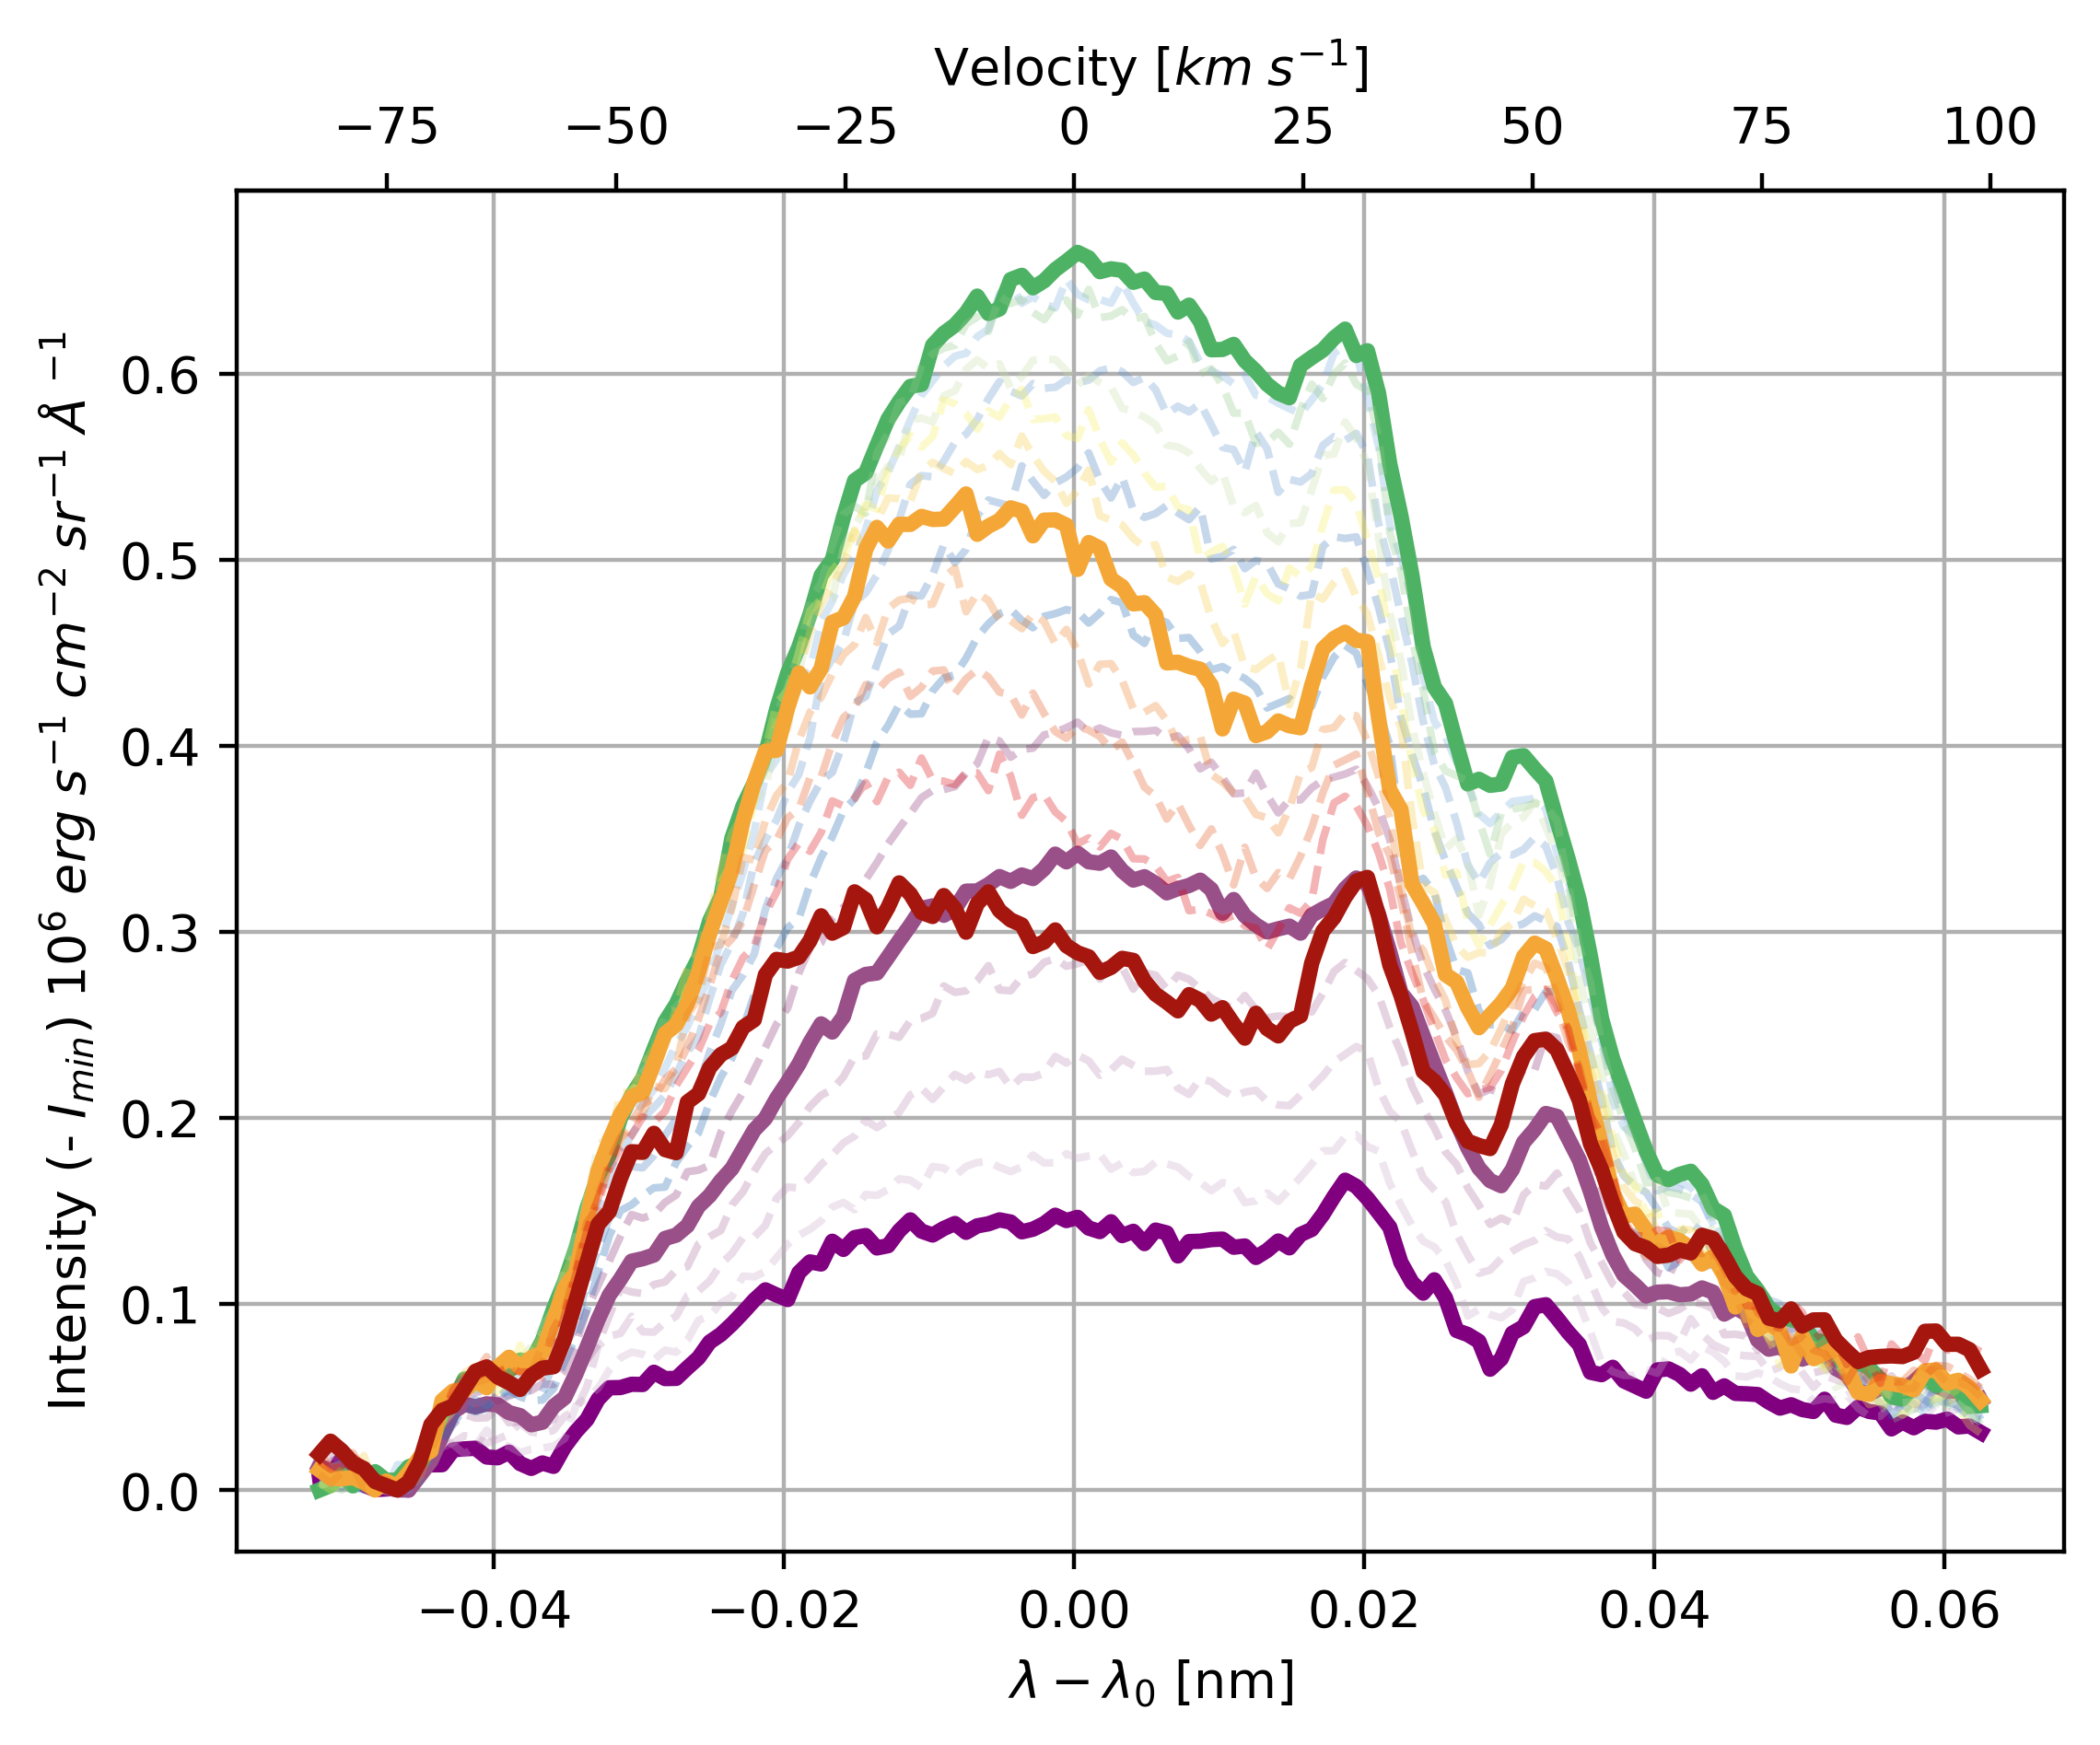

In [87]:
n = 20
colors = plt.cm.jet(np.linspace(0,1,n))

fig,ax=plt.subplots(dpi=400)
for i in range(n):
    if i == 0:
        ax.plot(selwlshift_hep,sels_hep[i]/1e6,color='purple',linewidth=3)
    elif i == 4 or i==10 or i == 15 or i == 19:
        ax.plot(selwlshift_hep,sels_hep[i]/1e6,color=cmap_choice[i],linewidth=3)
    else:
        ax.plot(selwlshift_hep,sels_hep[i]/1e6,color=cmap_choice[i],alpha=.3,linestyle='--')

ax.grid()
ax.set_xlabel(r'$\lambda - \lambda_0$ [nm]')
ax.set_ylabel(r'Intensity (- $I_{min}$) $10^6\; erg\;s^{-1}\; cm^{-2}\; sr^{-1}\; \AA\; ^{-1}$')
#ax.set_title('Ca II H flare-time emission across flare ribbon')
secaxx = ax.secondary_xaxis('top', functions=(veltrans,wltrans))
secaxx.set_xlabel(r'Velocity $[km\; s^{-1}]$')
#ax.annotate('Violet - leading edge\nYellow - trailing edge',[396.88,4e6])

In [126]:
forcentroids_hep = sels_scp_hep[10]
minval_hep = min(forcentroids_hep)
maxval_hep = max(forcentroids_hep)
levs_hep = np.linspace(minval_hep,maxval_hep,11)

In [127]:
levs_hep

array([     0.        ,  66514.42163   , 133028.84326   , 199543.26489   ,
       266057.68652001, 332572.10815001, 399086.52978001, 465600.95141001,
       532115.37304001, 598629.79467001, 665144.21630001])

In [128]:
leftindss_hep = []
rightindss_hep = []
levss_hep = []
centroidss_hep = []
centroidss0_hep = []
widths_hep = []
widths0_hep = []
sels_scp_hep =sels_hep
#generalize
for i in range(len(sels_hep)):
    forcentroids_hep = sels_scp_hep[i]
    minval_hep = min(forcentroids_hep)
    maxval_hep = max(forcentroids_hep)
    levs_hep = np.linspace(minval_hep,maxval_hep,11)
    
    levss_hep.append(levs_hep)
    
    leftinds_hep = []
    rightinds_hep = []
    leftvals_hep = []
    rightvals_hep = []

    for j in levs_hep:
        leftval_hep,leftind_hep = find_nearest(forcentroids_hep[0:round(len(forcentroids_hep)/2)],j)
        rightval_hep,rightind0_hep = find_nearest(forcentroids_hep[round(len(forcentroids_hep)/2):],j)
        rightind_hep = round(len(forcentroids_hep)/2)+rightind0_hep

        leftinds_hep.append(leftind_hep)
        rightinds_hep.append(rightind_hep)

        leftvals_hep.append(leftval_hep)
        rightvals_hep.append(rightval_hep)
    
    leftindss_hep.append(leftinds_hep)
    rightindss_hep.append(rightinds_hep)
    
    rightwls_hep = selwl_hep[rightinds_hep]
    leftwls_hep = selwl_hep[leftinds_hep]
    centroids_hep = []
    centroids0_hep = []

    for j in range(len(leftwls_hep)):
        rightwl_hep = rightwls_hep[j]
        leftwl_hep = leftwls_hep[j]
        centroids_hep.append(np.mean([rightwl_hep,leftwl_hep]))
        centroids0_hep.append(np.mean([rightwl_hep,leftwl_hep])-wl_hep)
        

    centroidss_hep.append(centroids_hep)
    centroidss0_hep.append(centroids0_hep)


In [129]:
leftwls_hep = selwl_hep[leftindss_hep]
rightwls_hep = selwl_hep[rightindss_hep]

In [130]:
leftwls_hep

array([[396.9611142 , 396.95650287, 396.97264251, 396.97417962,
        396.98032805, 396.98263372, 396.98493938, 396.9880136 ,
        396.99031926, 397.00569035, 397.00569035],
       [396.95957709, 396.96495697, 396.96649408, 396.97417962,
        396.97879095, 396.98186516, 396.98493938, 396.98724504,
        396.99031926, 397.01183878, 397.0064589 ],
       [396.95957709, 396.96341986, 396.97264251, 396.97417962,
        396.9795595 , 396.98263372, 396.98570793, 396.98878215,
        396.99185637, 396.9964677 , 397.00722746],
       [396.96034564, 396.96341986, 396.97264251, 396.97417962,
        396.97879095, 396.98263372, 396.98493938, 396.9880136 ,
        396.99185637, 396.99723625, 397.00569035],
       [396.9611142 , 396.96956829, 396.97264251, 396.97494817,
        396.9795595 , 396.98340227, 396.98647649, 396.98878215,
        396.99185637, 396.9980048 , 397.00722746],
       [396.96034564, 396.96341986, 396.97264251, 396.97494817,
        396.98032805, 396.98340227, 396.9

In [139]:
widths_hep = np.subtract(rightwls_hep,leftwls_hep)
#widths_hep = leftwls_hep-lamb1
np.shape(widths_hep)

(20, 11)

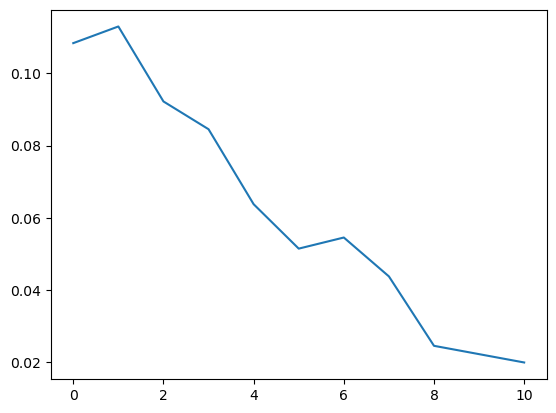

In [140]:
plt.plot(range(len(widths_hep[0])),widths_hep[0])

In [141]:
normlevss_hep = []
for i in range(len(levss_hep)):
    levs_hep = levss_hep[i]
    normlevss_hep.append(preprocessing.normalize([levs_hep]))

In [142]:
normlevss

[array([[0.        , 0.05096472, 0.10192944, 0.15289416, 0.20385888,
         0.2548236 , 0.30578831, 0.35675303, 0.40771775, 0.45868247,
         0.50964719]]),
 array([[0.        , 0.05096472, 0.10192944, 0.15289416, 0.20385888,
         0.2548236 , 0.30578831, 0.35675303, 0.40771775, 0.45868247,
         0.50964719]]),
 array([[0.        , 0.05096472, 0.10192944, 0.15289416, 0.20385888,
         0.2548236 , 0.30578831, 0.35675303, 0.40771775, 0.45868247,
         0.50964719]]),
 array([[0.        , 0.05096472, 0.10192944, 0.15289416, 0.20385888,
         0.2548236 , 0.30578831, 0.35675303, 0.40771775, 0.45868247,
         0.50964719]]),
 array([[0.        , 0.05096472, 0.10192944, 0.15289416, 0.20385888,
         0.2548236 , 0.30578831, 0.35675303, 0.40771775, 0.45868247,
         0.50964719]]),
 array([[0.        , 0.05096472, 0.10192944, 0.15289416, 0.20385888,
         0.2548236 , 0.30578831, 0.35675303, 0.40771775, 0.45868247,
         0.50964719]]),
 array([[0.        , 0.05096

In [143]:
if i == 0:
    ax.plot(selwl_hep,sels_hep[i]/1e6,color='purple',linewidth=3)
elif i == 4 or i==10 or i == 15 or i == 19:
    ax.plot(selwl_hep,sels_hep[i]/1e6,color=cmap_choice[i],linewidth=3)
else:
    ax.plot(selwl_hep,sels_hep[i]/1e6,color=cmap_choice[i],alpha=.3,linestyle='--')

Text(0, 0.5, 'Proportion of line height')

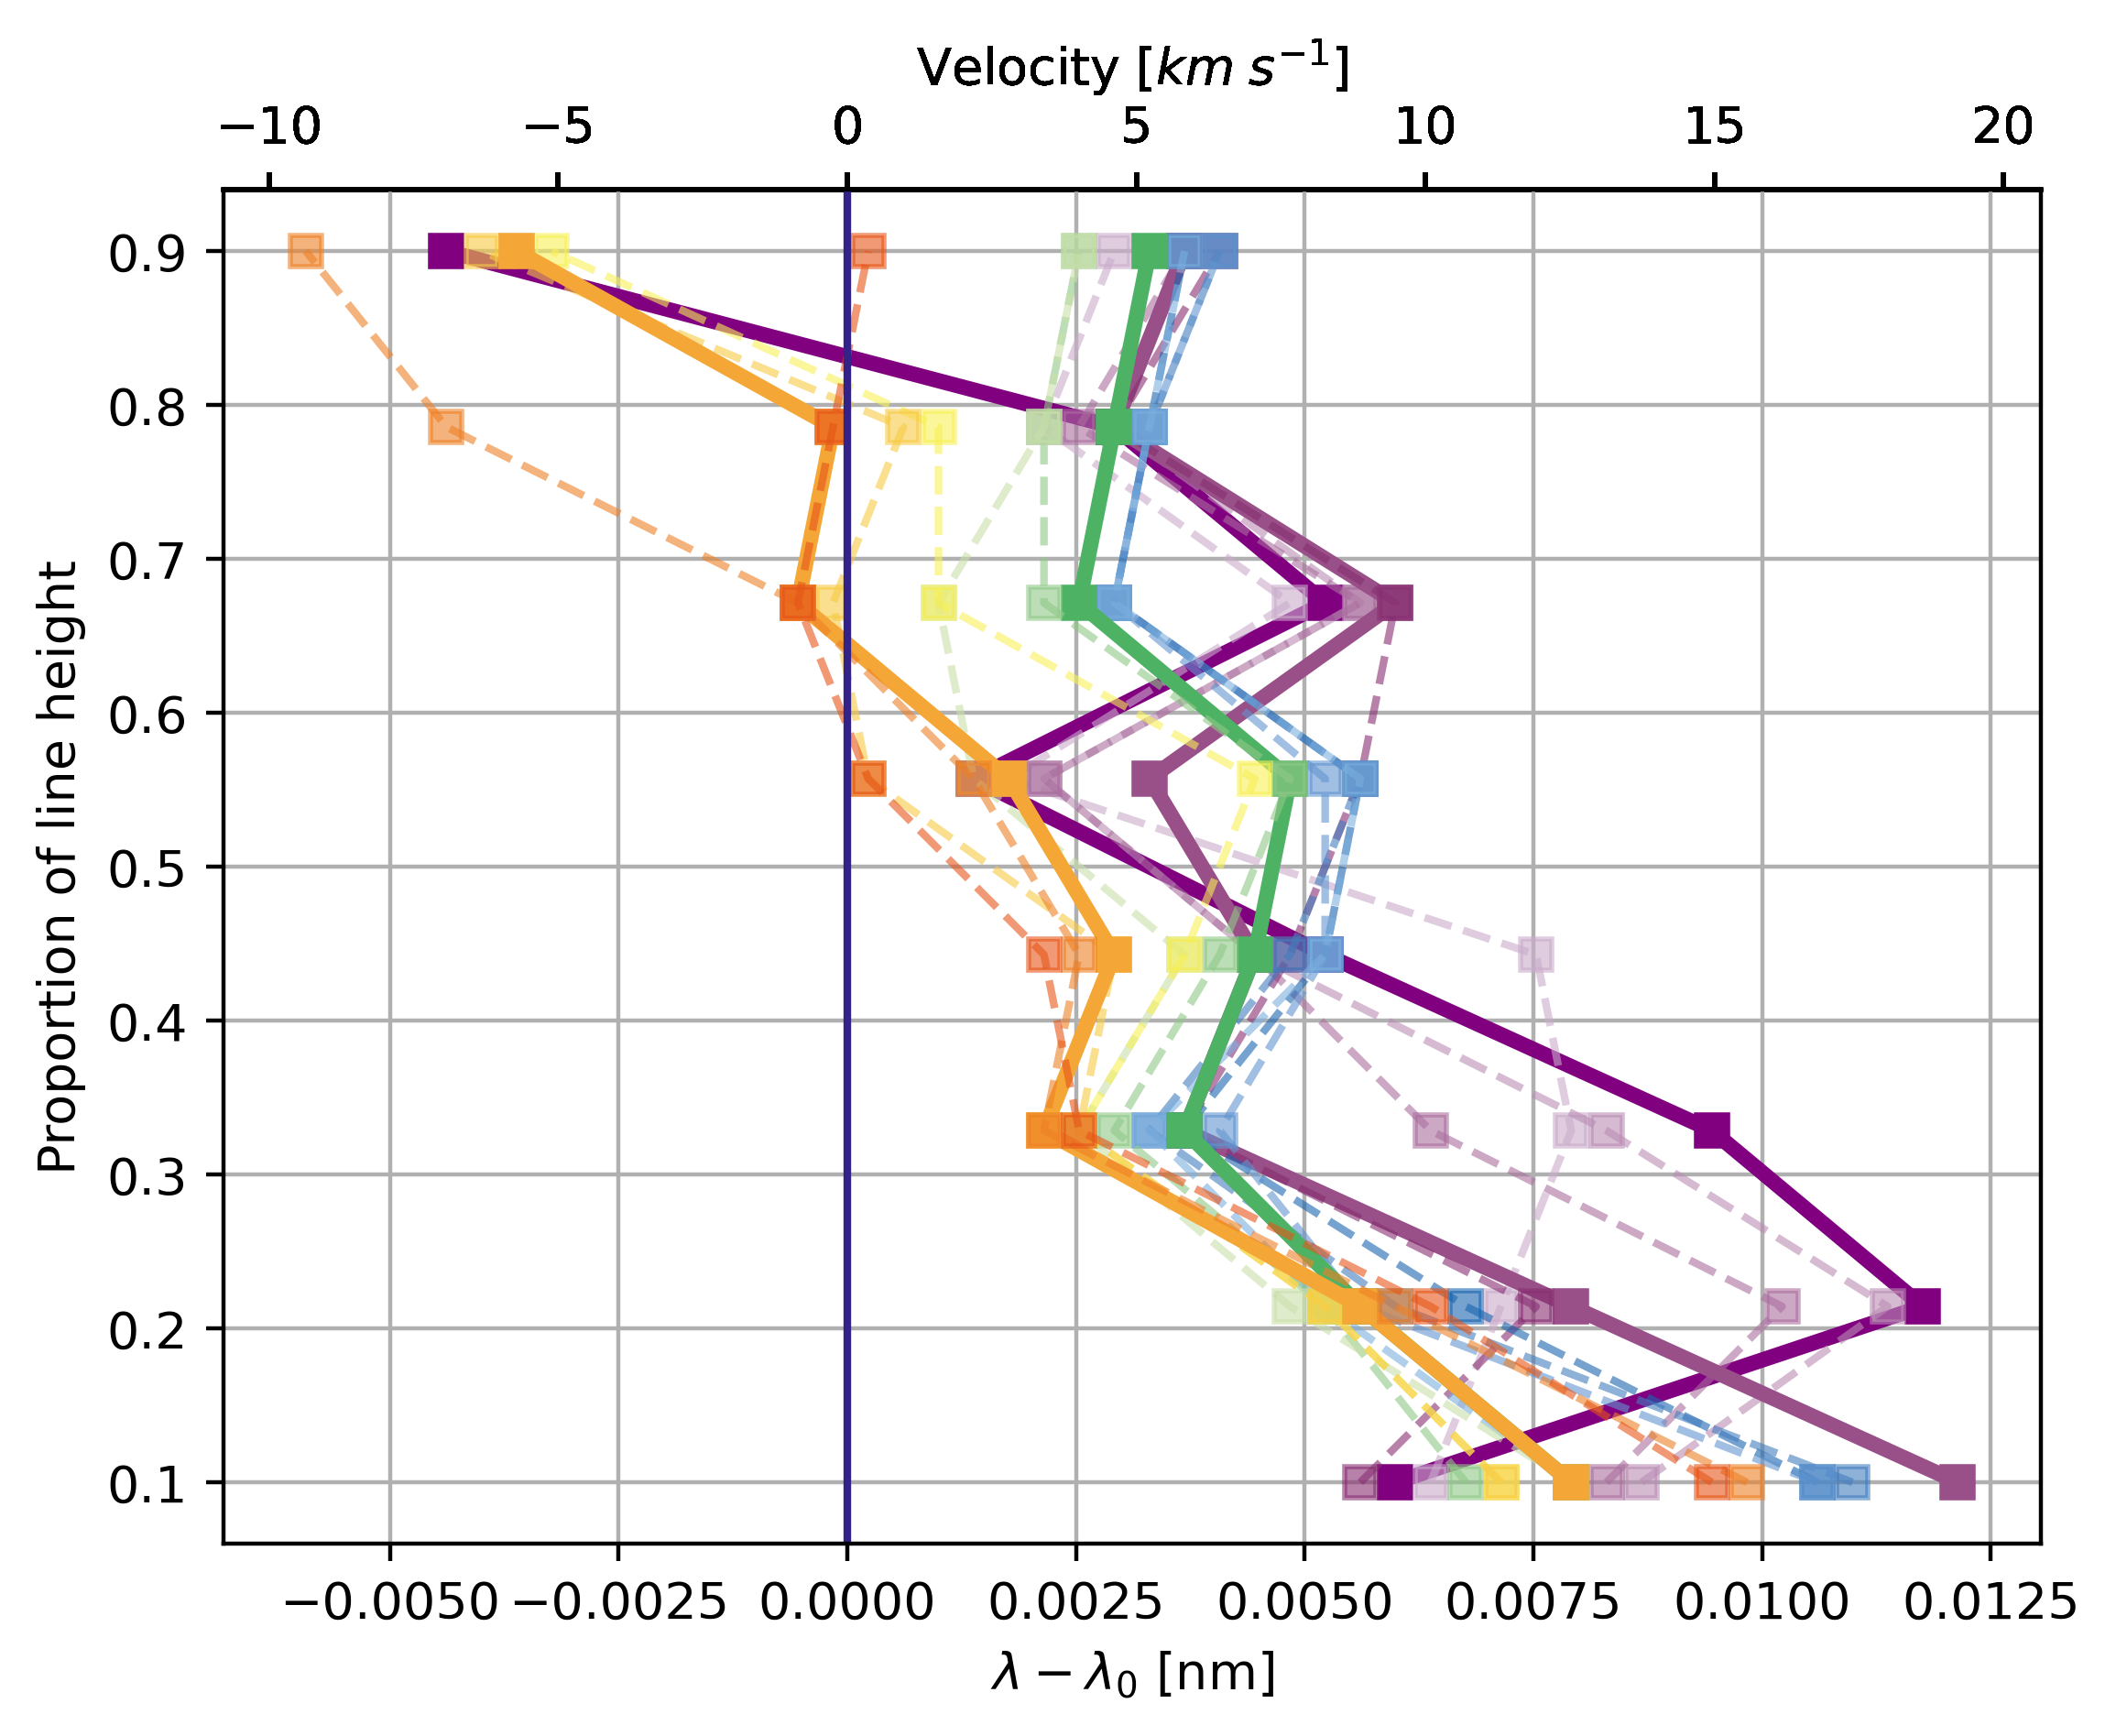

In [144]:
fig,ax=plt.subplots(dpi=400)

lamb1 = wl_hep
c=2.99e5
def veltrans_hep(x):
    return ((((x+lamb1)/lamb1)-1)*c)/mu
    #return ((((x+lamb0)/lamb0)-1)*c) #old, no mu angle difference

def wltrans_hep(x):
    return ((((x/c)+1)*lamb1)-lamb1)


for i in range(18):
    if i == 0:
        ax.plot(centroidss0_hep[i][1:-2],np.linspace(.1,.9,8),marker='s',color='purple',linewidth=3)
    elif i == 4 or i==10 or i == 15 or i == 19:
        ax.plot(centroidss0_hep[i][1:-2],np.linspace(.1,.9,8),marker='s',color=cmap_choice[i],linewidth=3)
    else:
        ax.plot(centroidss0_hep[i][1:-2],np.linspace(.1,.9,8),marker='s',color=cmap_choice[i],linestyle='--',alpha=.6)
    secaxx = ax.secondary_xaxis('top', functions=(veltrans_hep,wltrans_hep))
    secaxx.set_xlabel(r'Velocity $[km\; s^{-1}]$')
ax.grid()
ax.axvline(0,color='#332288')
ax.set_xlabel(r'$\lambda - \lambda_0$ [nm]')
ax.set_ylabel('Proportion of line height')

Text(0, 0.5, 'Proportion of line height')

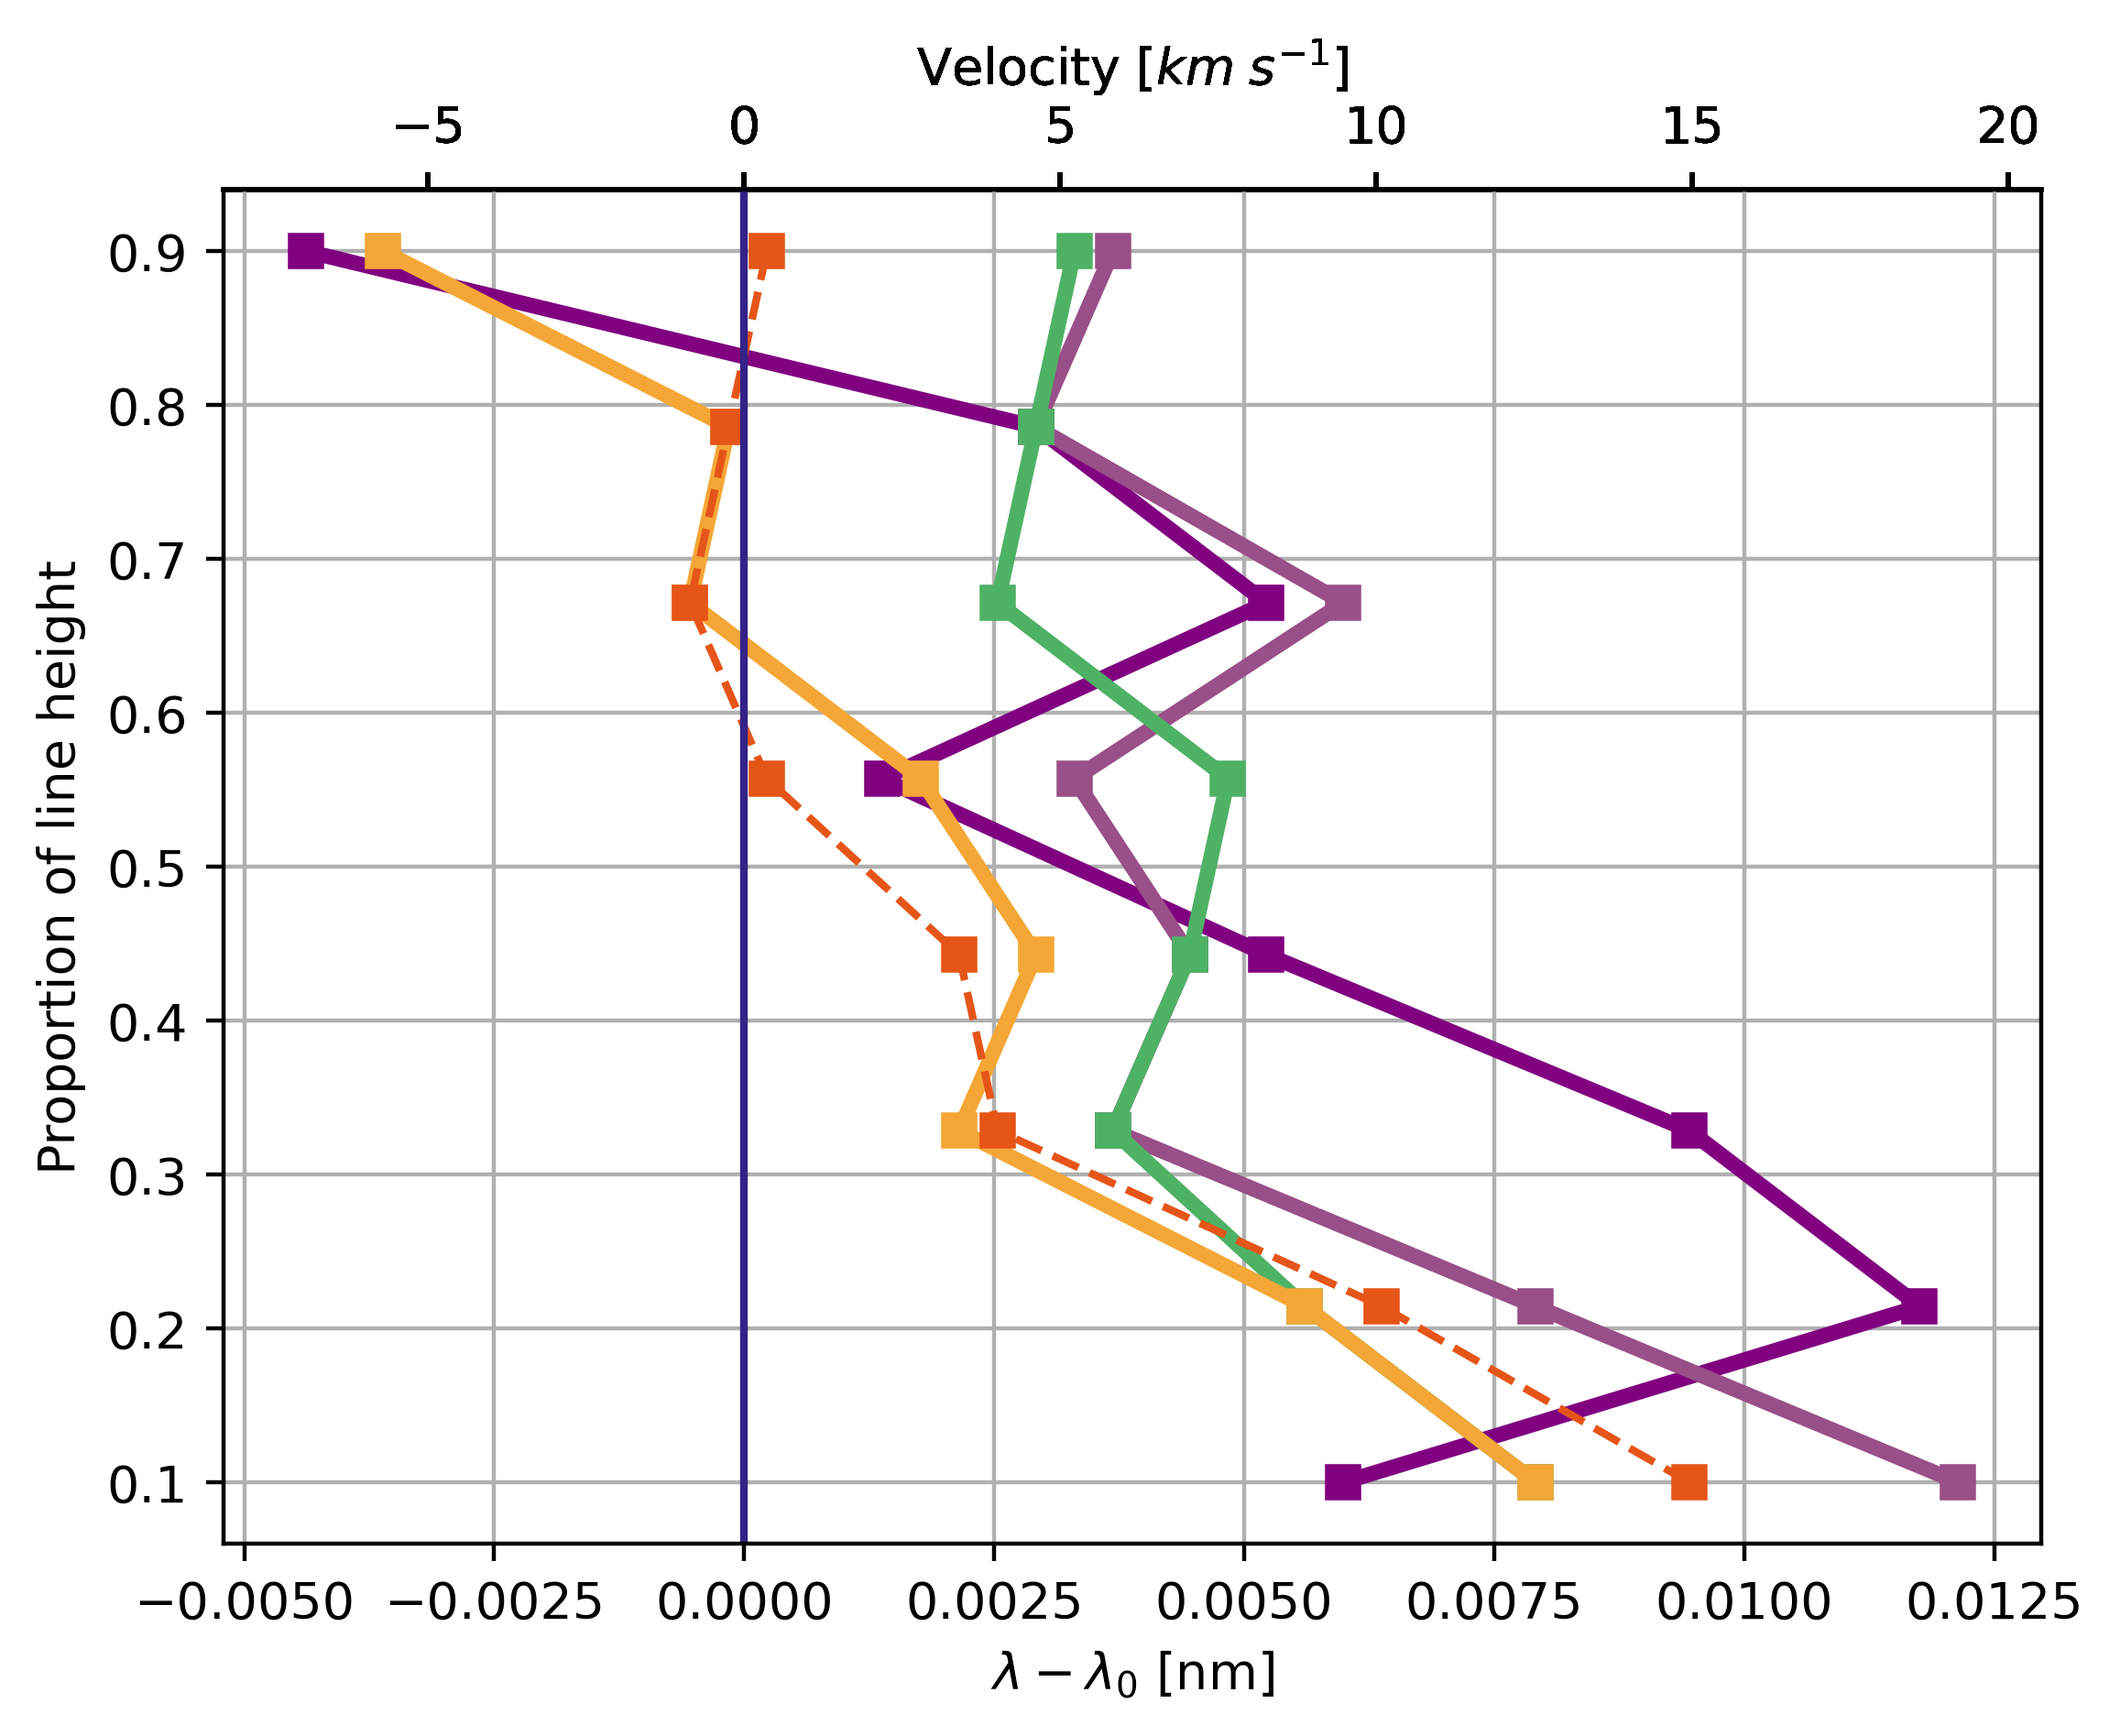

In [145]:
fig,ax=plt.subplots(dpi=400)



for i in range(18):
    if i == 0:
        ax.plot(centroidss0_hep[i][1:-2],np.linspace(.1,.9,8),marker='s',color='purple',linewidth=3)
    elif i == 4 or i==10 or i == 15:
        ax.plot(centroidss0_hep[i][1:-2],np.linspace(.1,.9,8),marker='s',color=cmap_choice[i],linewidth=3)
    elif i == 17:
        ax.plot(centroidss0_hep[i][1:-2],np.linspace(.1,.9,8),marker='s',color=cmap_choice[i],linestyle='--',alpha=1)
    secaxx = ax.secondary_xaxis('top', functions=(veltrans_hep,wltrans_hep))
    secaxx.set_xlabel(r'Velocity $[km\; s^{-1}]$')
ax.grid()
ax.axvline(0,color='#332288')
ax.set_xlabel(r'$\lambda - \lambda_0$ [nm]')
ax.set_ylabel('Proportion of line height')

Text(0, 0.5, 'Proportion of line height')

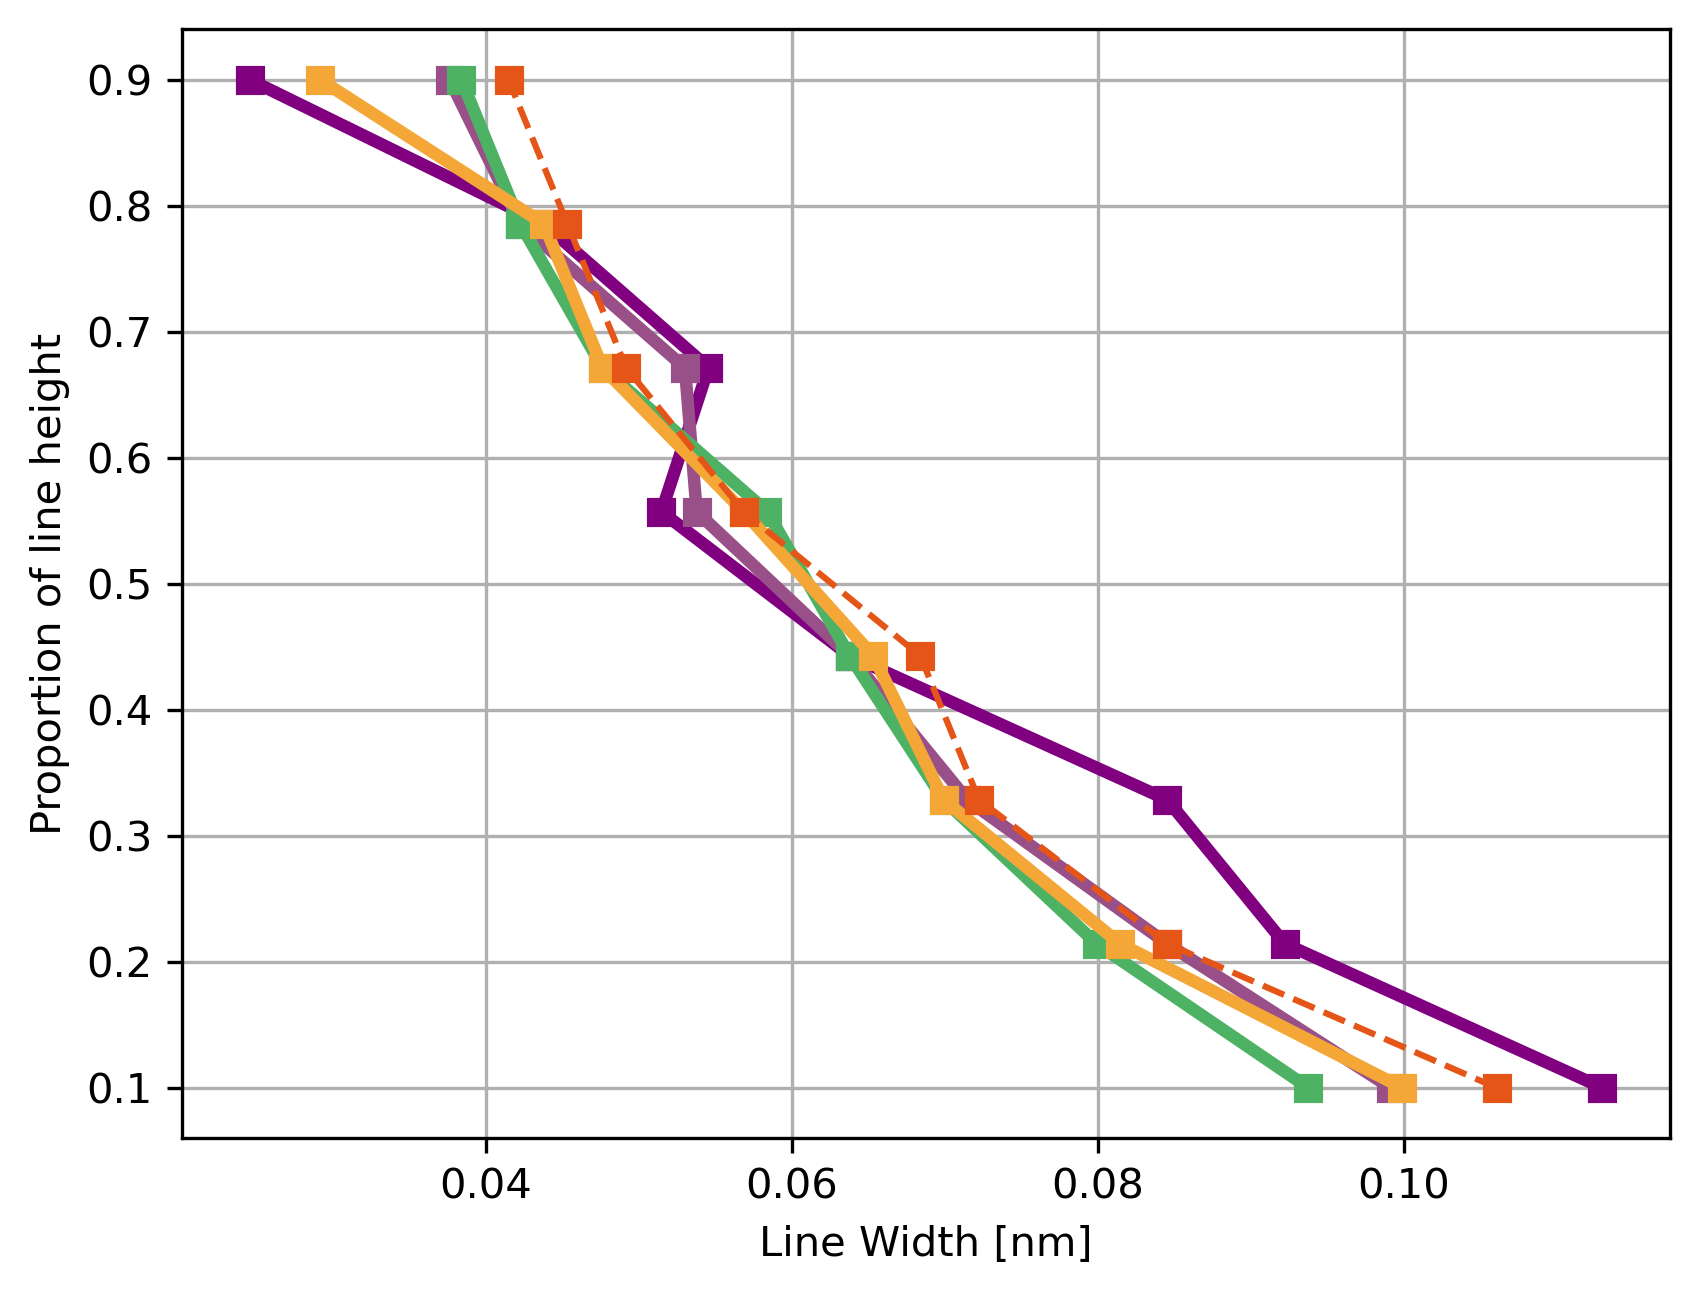

In [146]:
fig,ax=plt.subplots(dpi=300)

for i in range(18):
    if i == 0:
        ax.plot(widths_hep[i][1:-2],np.linspace(.1,.9,8),marker='s',color='purple',linewidth=3)
    elif i == 4 or i==10 or i == 15:
        ax.plot(widths_hep[i][1:-2],np.linspace(.1,.9,8),marker='s',color=cmap_choice[i],linewidth=3)
    elif i == 17:
        ax.plot(widths_hep[i][1:-2],np.linspace(.1,.9,8),marker='s',color=cmap_choice[i],linestyle='--',alpha=1)

    # else:
    #     ax.plot(widths[i][1:-2],np.linspace(.1,.9,8),marker='s',color=cmap_choice[i],linestyle='--',alpha=.8)
    # secaxx = ax.secondary_xaxis('top', functions=(veltrans,wltrans))
    # secaxx.set_xlabel(r'Line Width $[nm]$')
ax.grid()
secaxx.set_xlabel(r'Velocity $[km\; s^{-1}]$')
ax.set_xlabel(r'Line Width [nm]')
ax.set_ylabel('Proportion of line height')

In [151]:
lamb1-leftwls_hep

array([[ 0.0458858 ,  0.05049713,  0.03435749,  0.03282038,  0.02667195,
         0.02436628,  0.02206062,  0.0189864 ,  0.01668074,  0.00130965,
         0.00130965],
       [ 0.04742291,  0.04204303,  0.04050592,  0.03282038,  0.02820905,
         0.02513484,  0.02206062,  0.01975496,  0.01668074, -0.00483878,
         0.0005411 ],
       [ 0.04742291,  0.04358014,  0.03435749,  0.03282038,  0.0274405 ,
         0.02436628,  0.02129207,  0.01821785,  0.01514363,  0.0105323 ,
        -0.00022746],
       [ 0.04665436,  0.04358014,  0.03435749,  0.03282038,  0.02820905,
         0.02436628,  0.02206062,  0.0189864 ,  0.01514363,  0.00976375,
         0.00130965],
       [ 0.0458858 ,  0.03743171,  0.03435749,  0.03205183,  0.0274405 ,
         0.02359773,  0.02052351,  0.01821785,  0.01514363,  0.0089952 ,
        -0.00022746],
       [ 0.04665436,  0.04358014,  0.03435749,  0.03205183,  0.02667195,
         0.02359773,  0.02052351,  0.01821785,  0.01437508,  0.0105323 ,
        -0.000

Text(0, 0.5, 'Proportion of line height')

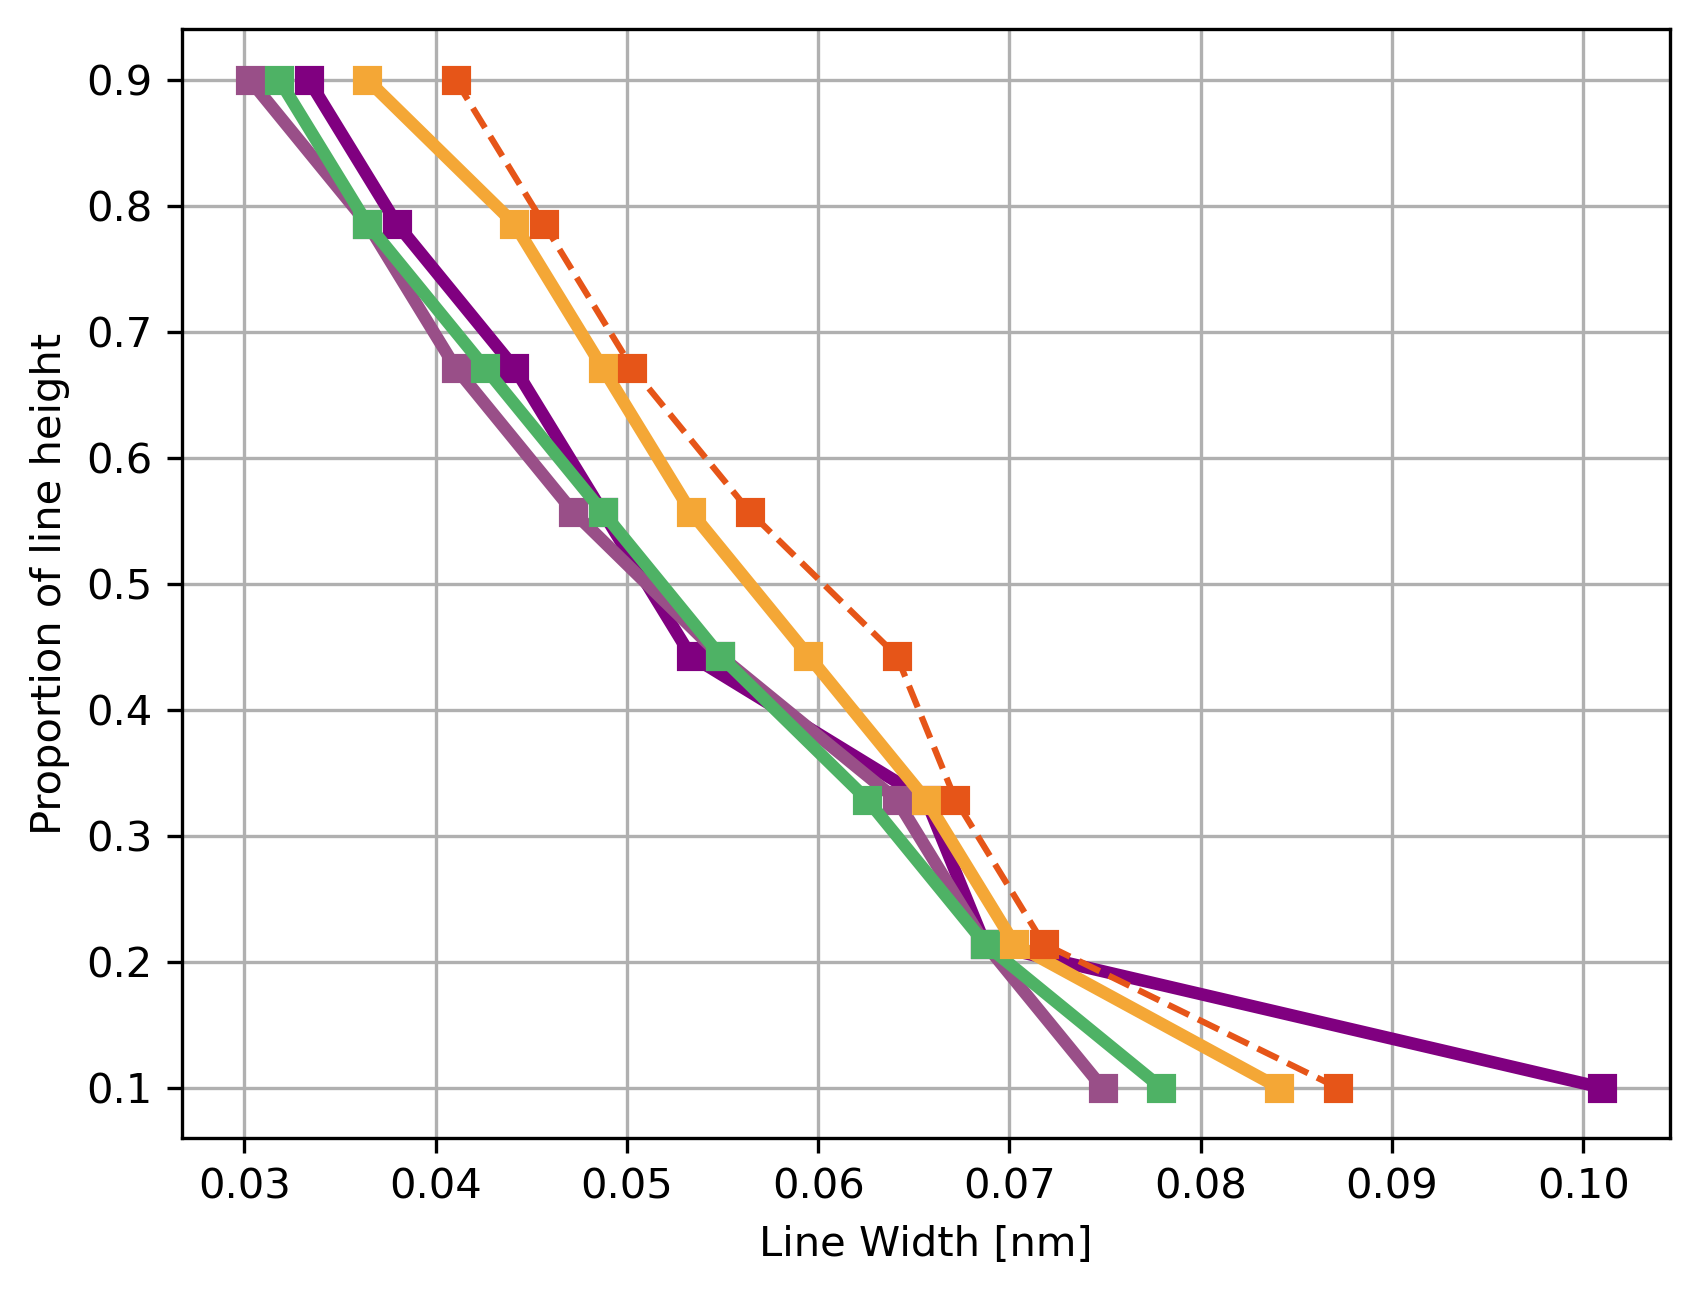

In [152]:
#widths_hep = np.subtract(rightwls_hep,leftwls_hep)
widths_hep_2 = 2*(lamb1-leftwls_hep)
np.shape(widths_hep_2)

fig,ax=plt.subplots(dpi=300)

for i in range(18):
    if i == 0:
        ax.plot(widths_hep_2[i][1:-2],np.linspace(.1,.9,8),marker='s',color='purple',linewidth=3)
    elif i == 4 or i==10 or i == 15:
        ax.plot(widths_hep_2[i][1:-2],np.linspace(.1,.9,8),marker='s',color=cmap_choice[i],linewidth=3)
    elif i == 17:
        ax.plot(widths_hep_2[i][1:-2],np.linspace(.1,.9,8),marker='s',color=cmap_choice[i],linestyle='--',alpha=1)

    # else:
    #     ax.plot(widths[i][1:-2],np.linspace(.1,.9,8),marker='s',color=cmap_choice[i],linestyle='--',alpha=.8)
    # secaxx = ax.secondary_xaxis('top', functions=(veltrans,wltrans))
    # secaxx.set_xlabel(r'Line Width $[nm]$')
ax.grid()
secaxx.set_xlabel(r'Velocity $[km\; s^{-1}]$')
ax.set_xlabel(r'Line Width [nm]')
ax.set_ylabel('Proportion of line height')

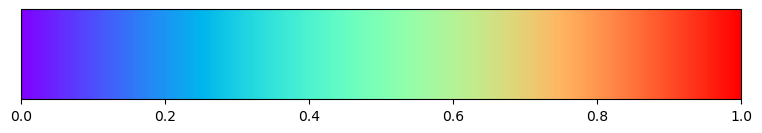

In [98]:
a = np.array([[0,1]])
plt.figure(figsize=(9, 1.5))
img = plt.imshow(a, cmap="rainbow")
plt.gca().set_visible(False)
cax = plt.axes([0.1, 0.2, 0.8, 0.6])
plt.colorbar(orientation="horizontal", cax=cax)